# Trying Unified Noise Model and Zero-noise Extrapolation over Qubit Unitary Inversion Circuit

## General imports and variables

In [1]:
%cd ../project/unified_noise_model
from Unified_Noise_Model import Unified_Noise_Model
from qiskit_ibm_provider import IBMProvider
%cd ../../QPL_experiment

import numpy as np
from numpy import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, quantum_info
from qiskit.providers.aer import Aer,AerSimulator
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.circuit.library.standard_gates import HGate,YGate,CXGate,RYGate,CCXGate,XGate,ZGate
import pylatexenc
from qiskit.qasm2 import dump
from mitiq.zne.inference import LinearFactory,RichardsonFactory,PolyExpFactory
from mitiq.zne.scaling import fold_gates_at_random,fold_global
from mitiq import zne
import json
import matplotlib.pyplot as plt


C:\Users\Adriano\Desktop\Facultad\Facultad\Trabajos\QuantumQuipu\Noise and native gates\QuantumQuipu_NoiseAndNativeGates\Codigo\project\unified_noise_model
C:\Users\Adriano\Desktop\Facultad\Facultad\Trabajos\QuantumQuipu\Noise and native gates\QuantumQuipu_NoiseAndNativeGates\Codigo\QPL_experiment


In [2]:
token = '825a8b2e6fb861f63088f866e59357e49447b4b9b24ff6136e56dcc28f2fb0cedda6c2976b9e2aef48129a80864265494be7f8a7aae5b9ebd6654a7d80d9b5cb'

## Qubit unitary inversion circuit

Here, we show how it can be construct the Qubit unitary inversion circuit. These cells were took from the original authors repo: https://github.com/sy3104/deterministic_exact_unitary_inversion/blob/main/qubit_unitary_inversion_circuit.ipynb

C:\Users\Adriano\anaconda3\envs\quantum\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


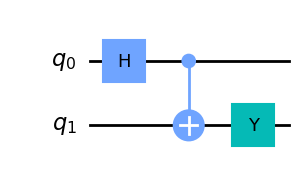

In [3]:
#transformation from |00> to |psi^->:=(|01>-|10>)/sqrt(2)
Vas_q = QuantumRegister(2, 'q')
Vas = QuantumCircuit(Vas_q, name='Vas')
Vas.h(0)
Vas.cx(0,1)
Vas.y(1)
Vas.draw('mpl')

In [4]:
#CG transform of 1+1 qubits
#Transformation from |i_1 i_2 0> to |j_1 m_1 m_2>
q = QuantumRegister(3, 'q')
CG2 = QuantumCircuit(q, name='CG2')
CG2.ccx(q[0],q[1],q[2])
CG2.cx(q[1],q[0])
CG2.append(RYGate(pi/2).control(1,ctrl_state=0), [q[2],q[1]])
CG2.append(RYGate(pi/2).control(2,ctrl_state=0), [q[2],q[0],q[1]])
CG2.cx(q[1],q[0],ctrl_state=0)
CG2.swap(q[0],q[1])
CG2.swap(q[1],q[2])

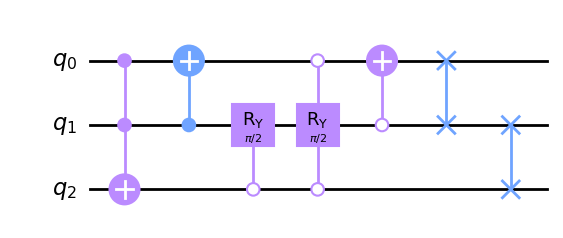

In [5]:
CG2.draw('mpl')

In [6]:
#CG transform of 2+1 qubits
#Transformation from |j_1 m_1 m_2 i_3> to |j'_1 m'_1 m'_2 p'_3>
theta=2.0*np.arccos(np.sqrt(2/3))

q = QuantumRegister(4, 'q')
CG3 = QuantumCircuit(q, name='CG3')

CG3.cx(q[0],q[2],ctrl_state=0)
CG3.ccx(q[2],q[3],q[1])
CG3.cx(q[3],q[2])
CG3.cx(q[1],q[2])
CG3.append(RYGate(pi).control(1,ctrl_state=0),[q[1],q[3]])
CG3.append(RYGate(-theta).control(3,ctrl_state=5),[q[0],q[1],q[2],q[3]])
CG3.append(RYGate(theta).control(3,ctrl_state=7),[q[0],q[1],q[2],q[3]])
CG3.cx(q[3],q[0])
CG3.x(q[0])
CG3.swap(q[1],q[2])
CG3.x(q[1])
CG3.cx(q[0],q[1])
CG3.cswap(q[0],q[1],q[2])
CG3.ccx(q[0],q[1],q[2])

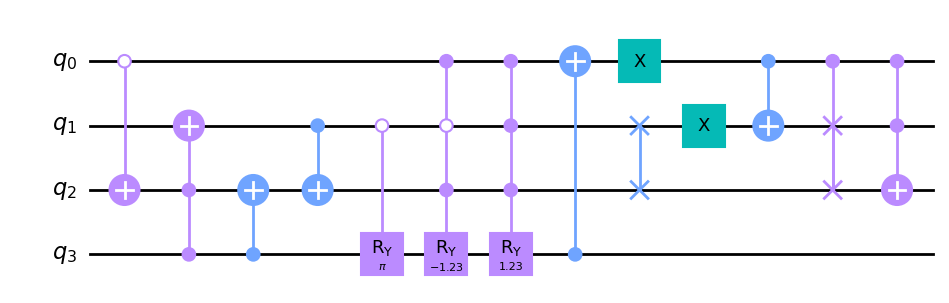

In [7]:
CG3.draw('mpl')

In [8]:
#Input unitary is chosen randomly
Uin =quantum_info.random_unitary(2)

In [9]:
#a block of quantum circuit using 2 calls of the input unitary
q = QuantumRegister(3, 'q')
a = QuantumRegister(4, 'aux')
block = QuantumCircuit(q,a, name='block')

block.unitary(Uin, q[1], label="Uin")
block.append(CG2, [q[0],q[1],a[0]])
block.cx(q[0], a[3], ctrl_state=1)
block.append(CG3.inverse(), [a[1],a[2],q[2],a[3]])
block.unitary(Uin, a[3], label="Uin")
block.append(CG3, [q[0],q[1],a[0],a[3]])
block.cx(a[1],a[3], ctrl_state=1)
block.append(CG2.inverse(), [a[1], a[2], q[2]])
block.swap(a[0],q[0])
block.swap(a[2],q[1])
block.swap(a[1],q[2])

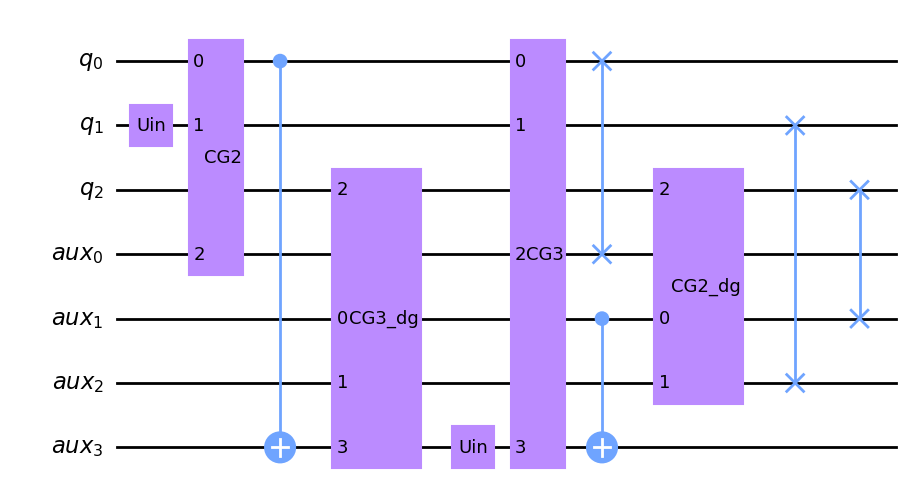

In [10]:
block.draw('mpl')

In [11]:
#Unitary inversion circuit
#Transforming |\psi, 0, 0> to (U\otimes \1)|as>\otimes U^-1 |\psi>
q = QuantumRegister(3, 'q')
a = QuantumRegister(4, 'aux')
circ = QuantumCircuit(q,a,name='circ')

circ.append(Vas,[q[1],q[2]])
circ.append(block, [q[0],q[1],q[2],a[0],a[1],a[2],a[3]])
circ.append(block, [q[0],q[1],q[2],a[0],a[1],a[2],a[3]])

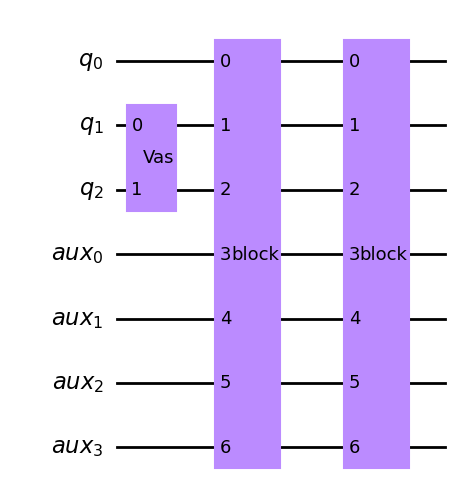

In [12]:
circ.draw('mpl')

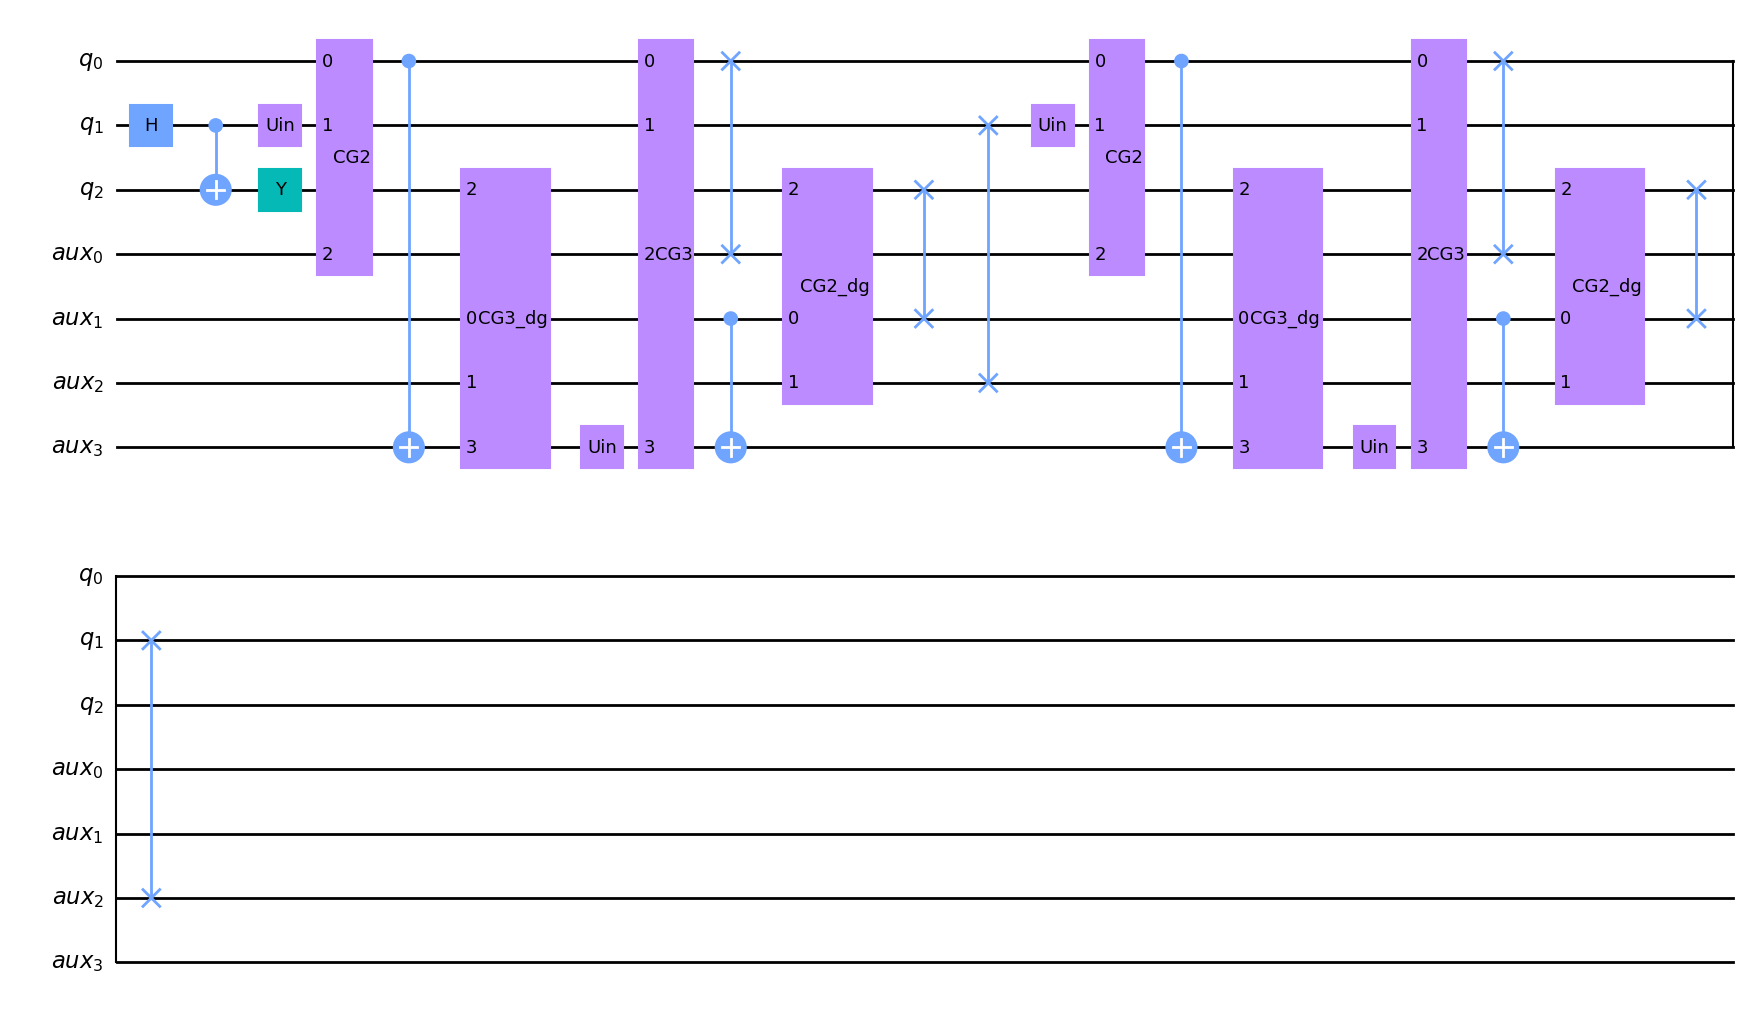

In [13]:
circ=circ.decompose()
circ.draw('mpl')

In [14]:
#Unitary to prepare input state from |0>
prep=quantum_info.random_unitary(2)

In [15]:
#Checking that "circ" implements a transformation from |\psi, 0, 0> to (U\otimes I)|as>\otimes U^-1 |\psi>
q = QuantumRegister(3, 'q')
a = QuantumRegister(4, 'aux')
c = ClassicalRegister(3, 'c')
check_circ = QuantumCircuit(q,a,c)

check_circ.unitary(prep,q[0],label="prep")
check_circ.append(circ, [q[0],q[1],q[2],a[0],a[1],a[2],a[3]])
check_circ.unitary(Uin, q[2], label="Uin")
check_circ.unitary(prep.adjoint(), q[2], label="prep_dg")
check_circ.unitary(Uin.adjoint(), q[0], label='Uin_dg')
check_circ.append(Vas.inverse(), [q[0],q[1]])
check_circ.measure(q[0],c[0])
check_circ.measure(q[1],c[1])
check_circ.measure(q[2],c[2])

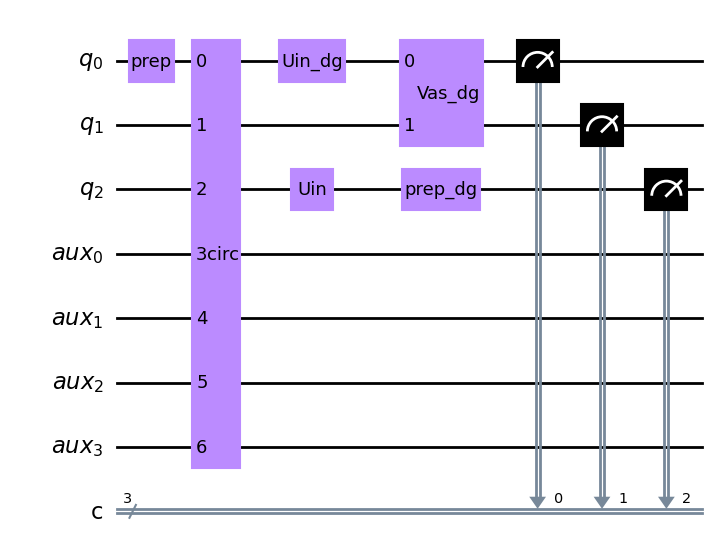

In [16]:
check_circ.draw('mpl')

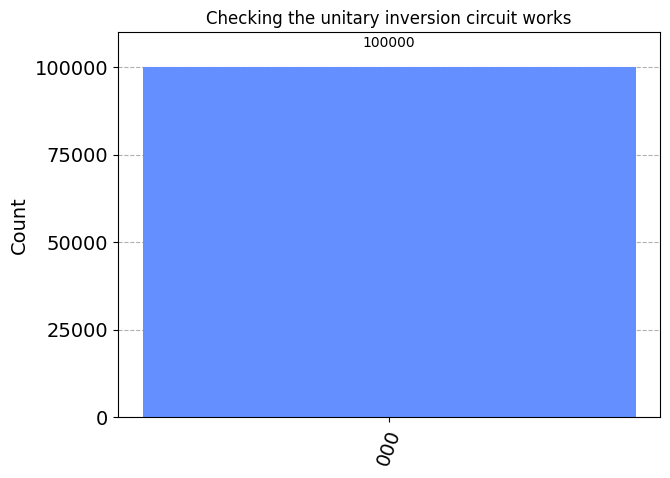

In [17]:
# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
check_circ = transpile(check_circ, simulator)

# Run and get counts
result = simulator.run(check_circ,shots=100000).result()
counts = result.get_counts(check_circ)
plot_histogram(counts, title='Checking the unitary inversion circuit works')

## Unitary inverser to use

We construct the qubit unitary inversion circuit that will be used through out our experiment.

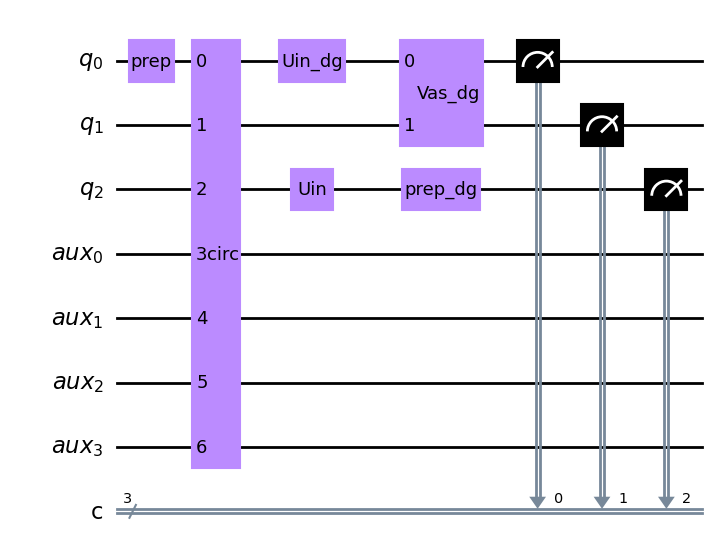

In [18]:
prep=quantum_info.random_unitary(2)

q = QuantumRegister(3, 'q')
a = QuantumRegister(4, 'aux')
c = ClassicalRegister(3, 'c')
u_inverser = QuantumCircuit(q,a,c)

u_inverser.unitary(prep,q[0],label="prep")
u_inverser.append(circ, [q[0],q[1],q[2],a[0],a[1],a[2],a[3]])

u_inverser.unitary(Uin, q[2], label="Uin")
u_inverser.unitary(prep.adjoint(), q[2], label="prep_dg")
u_inverser.unitary(Uin.adjoint(), q[0], label='Uin_dg')
u_inverser.append(Vas.inverse(), [q[0],q[1]])

u_inverser.measure(q[0],c[0])
u_inverser.measure(q[1],c[1])
u_inverser.measure(q[2],c[2])
u_inverser.draw('mpl')

## Ideal result

These are the ideal counts over the $u\_inverser$. You can see it only output '$000$' because our circuit is applying the algorithm + its inverse.

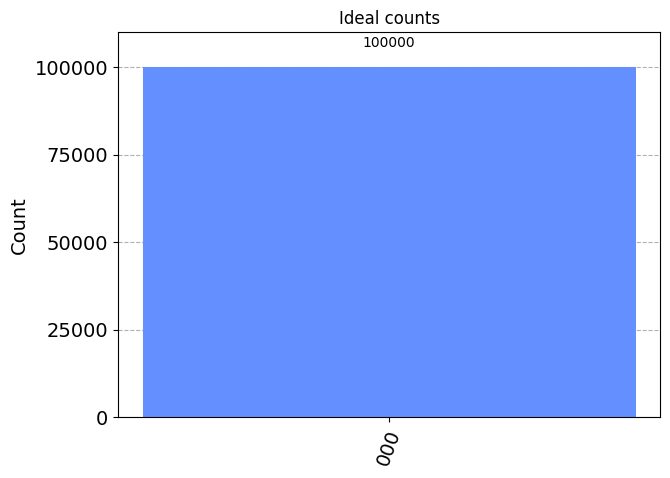

In [19]:
simulator = Aer.get_backend('aer_simulator')
u_inverser_ideal= transpile(u_inverser, simulator)

# Run and get counts
result = simulator.run(u_inverser_ideal,shots=100000).result()
counts = result.get_counts(u_inverser_ideal)
plot_histogram(counts, title='Ideal counts')

## Experiment

We will run  multiple experiments on IBM QPUs:
* ibm_brisbane (SOLO CON BRISBANE HASTA AHORA, PUEDO HACERLO CON KYOTO Y ESTUVE TENIENDO PROBS CON OSAKA)
* ibm_osaka
* ibm_kyoto

These experiments will be:
1. $u\_inverser$ on the QPU
2. $\textbf{NO HECHO AUN,CREO QUE NO LO HARE}$ $u\_inverser$ on the QPU and applying zero-noise extrapolation
3. $u\_inverser$ on a UNM simulation of the QPU
3. $u\_inverser$ on a UNM simulation of the QPU and applying zero-noise extrapolation

For the ZNE experiments, we will try four combinations of it:
* linearOne - LinearFactory(scale_factors=[1,6]),
* richOne - RichardsonFactory(scale_factors=[1,2,6])
* richTwo - RichardsonFactory(scale_factors=[1,1.22,1.44,1.66,2])
* richThree - RichardsonFactory(scale_factors=[1,1.26,1.52,3,6])]

We will run a sample of 100 mitigations for each combination, from that we will store some observables of it like:
* success probability: the probability that the mitigation ends on an extrapolation nearer to the ideal count than the not-mitigated count.
* average of the percentual relative error over the succed mitigations: this is, the mean over each percentual relative error between a succeed count and the ideal count.
* average of the percentual relative error over the failed mitigations: this is, the average over each percentual relative error between a failed count and the ideal count.
* average of the percentual relative error over all mitigations
* average improvement on succed mitigations: this is an average improvament that could be get in counts when a mitigation succed.
* average deterioration on failed mitigations: this is an average deterioration that could be get in counts when a mitigation failed.

VICTOR, HAY ALGUNAS COSAS COMENTADAS O HARDCODEADAS EN EL CODIGO DE ABAJO PORQUE ESTUVE HASTA EL VIERNES A LA NOCHE CODEANDO, PERO SON DETALLITOS. MAS QUE NADA PARA FORZAR SALTEARME CIERTAS ITERACIONES EN LOS BUCLES FOR.

In [20]:
#MOSTRAR BACKENDS DE IBMQ
IBMProvider.save_account(token= token, overwrite=True)
provider = IBMProvider()
print(provider.backends())

[<IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>]


In [21]:
def create_executor(observable,shots,device):
    def executor(circuit):
        result = device.run(circuit,shots=shots).result()
        counts = result.get_counts(circuit)
        #print(counts)
        return counts[observable]
    return executor

In [47]:
def mitigation_experiment(circuit,simulator,shots,factory,factory_name):
    # first ZNE configuration
    n_sample = 100

    zne_exp_result = {}
    zne_exp_result['success_prob'] = 0
    zne_exp_result['avg_rel_error_on_success'] = 0
    zne_exp_result['avg_rel_error_on_fail'] = 0
    zne_exp_result['rel_error'] = 0
    zne_exp_result['avg_improvement_on_success'] = 0
    zne_exp_result['avg_deterioration_on_fail'] = 0
    
    success_extrapolations = []
    fail_extrapolations = []
    success_counts_without_mit = []
    fail_counts_without_mit= []
    n_sample_where_extrapolation_is_better_than_nomit = 0
    
    for i in range(n_sample):
        print('SAMPLE ',i)
        executor =create_executor('000',shots,simulator)
        extrapolation = zne.execute_with_zne(circuit, executor,factory=factory,scale_noise= fold_gates_at_random,num_to_average=1)
        count_without_mit = factory.get_expectation_values()[0]
        print('extrapolalation:',extrapolation)
        print('expectation_values:',factory.get_expectation_values())
        display(factory.plot_fit())
        plt.close()
        #is the extrapolation better than the ideal count?
        if(extrapolation <= shots and extrapolation > count_without_mit):
            print('is better!')
            success_extrapolations.append(extrapolation)
            success_counts_without_mit.append(count_without_mit)
            n_sample_where_extrapolation_is_better_than_nomit= n_sample_where_extrapolation_is_better_than_nomit + 1
        else:
            print('is worse')
            fail_extrapolations.append(extrapolation)
            fail_counts_without_mit.append(count_without_mit)

    #we know this value because we get it before
    ideal_count = 10000  
    zne_exp_result['success_prob'] = n_sample_where_extrapolation_is_better_than_nomit / n_sample

    zne_exp_result['avg_rel_error_on_success'] = np.mean(
        [np.abs(ideal_count - extrapolation) / ideal_count for extrapolation in success_extrapolations]   
    ) * 100

    zne_exp_result['avg_rel_error_on_fail'] = np.mean(
        [np.abs(ideal_count - extrapolation) / ideal_count for extrapolation in fail_extrapolations]   
    ) * 100

    extrapolations = success_extrapolations + fail_extrapolations
    zne_exp_result['rel_error'] =  np.mean(
        [np.abs(ideal_count - extrapolation) / ideal_count for extrapolation in extrapolations]   
    ) * 100

    zne_exp_result['avg_improvement_on_success'] = np.mean(
        [np.abs(success_counts_without_mit[i] - success_extrapolations[i]) for i in range(len(success_counts_without_mit))]
    )

    zne_exp_result['avg_deterioration_on_fail'] = np.mean(
        [np.abs(fail_counts_without_mit[i] - fail_extrapolations[i]) for i in range(len(fail_counts_without_mit))]
    )

    print('result: ',zne_exp_result)
    with open('./%s_%s_%s_result'%(str(qpu),str(condition),str(factory_name)), 'w') as archivo:
            json.dump(zne_exp_result, archivo)

    

............................................................
-----------------------------------------------------------
CURRENT QPU: ibm_brisbane
-----------------------------------------------------------
............................................................
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all 

{0: 0.0001961413085,
 1: 0.0001390148586,
 2: 0.0001952864722,
 3: 0.0001730525105,
 4: 0.0001204532456,
 5: 0.0001707168243,
 6: 0.0009056918192,
 7: 0.0003571303054,
 8: 0.0001505783253,
 9: 0.0002293269386,
 10: 0.0002511333926,
 11: 0.0002054500929,
 12: 0.0001719717855,
 13: 0.0002304662631,
 14: 0.000158362268,
 15: 0.0004725500845,
 16: 0.0002379246317,
 17: 0.000157310208,
 18: 0.0005412709849,
 19: 0.0002451177689,
 20: 0.0002362666872,
 21: 0.0001980841174,
 22: 0.0006769925071,
 23: 0.0002121197628,
 24: 0.0002614348053,
 25: 0.0002305295935,
 26: 0.0002176629987,
 27: 0.0001868456084,
 28: 0.0003267881442,
 29: 9.148835863e-05,
 30: 0.0003042057402,
 31: 0.0001945542845,
 32: 0.0004683667826,
 33: 0.0002385741542,
 34: 0.000135303451,
 35: 0.0003359321188,
 36: 0.0002693026023,
 37: 0.0001562673298,
 38: 0.000445145933,
 39: 0.0009445263404,
 40: 0.0001769900315,
 41: 0.0001353344106,
 42: 0.000776938166,
 43: 0.001111620585,
 44: 0.000373830161,
 45: 0.001156831367,
 46: 0

------------------------------------------------
TWO QUBITS ERROR RATES:


{'1_0': 0.017671366073595096,
 '2_1': 0.008644540424665087,
 '3_2': 0.0066572605698366205,
 '4_5': 0.012109086985429701,
 '4_3': 0.004981406510880831,
 '4_15': 0.004864111959271167,
 '6_7': 0.005810400571444219,
 '6_5': 0.004950645834681466,
 '7_8': 0.007070007813789442,
 '8_9': 0.011639410457110116,
 '10_11': 0.004641250284009912,
 '10_9': 0.006924939199244501,
 '11_12': 0.003694510772123405,
 '12_17': 0.01229127058127899,
 '13_12': 0.006556591952591617,
 '14_0': 0.005560767111661702,
 '14_18': 0.006955072273549079,
 '15_22': 0.02204236246195626,
 '16_26': 0.006420033460741714,
 '16_8': 0.00580207785858583,
 '17_30': 0.006122792227557017,
 '18_19': 0.005845774812963778,
 '20_33': 0.03046905024159341,
 '20_19': 0.007681999485731894,
 '21_20': 0.005754961748584864,
 '21_22': 0.016238812402877528,
 '22_23': 0.0584293340815604,
 '24_34': 0.00852199497179415,
 '24_23': 0.005661103088163005,
 '25_24': 0.007475617133301693,
 '26_25': 0.01210240573318247,
 '27_26': 0.007096973786231864,
 '28_

------------------------------------------------
MEASUREMENT ERROR RATES:


{0: 0.0262,
 1: 0.0257,
 2: 0.0163,
 3: 0.0222,
 4: 0.0145,
 5: 0.0057,
 6: 0.0095,
 7: 0.0227,
 8: 0.0107,
 9: 0.0077,
 10: 0.0157,
 11: 0.133,
 12: 0.0141,
 13: 0.0173,
 14: 0.0185,
 15: 0.0115,
 16: 0.0176,
 17: 0.014,
 18: 0.0838,
 19: 0.0577,
 20: 0.0109,
 21: 0.0077,
 22: 0.0111,
 23: 0.0105,
 24: 0.206,
 25: 0.009,
 26: 0.0065,
 27: 0.0527,
 28: 0.0258,
 29: 0.0224,
 30: 0.0082,
 31: 0.0047,
 32: 0.0094,
 33: 0.0104,
 34: 0.0318,
 35: 0.0156,
 36: 0.0125,
 37: 0.0092,
 38: 0.0292,
 39: 0.0149,
 40: 0.0122,
 41: 0.0109,
 42: 0.0106,
 43: 0.023,
 44: 0.0176,
 45: 0.0357,
 46: 0.0121,
 47: 0.0087,
 48: 0.0147,
 49: 0.0075,
 50: 0.0124,
 51: 0.0121,
 52: 0.0081,
 53: 0.0119,
 54: 0.0186,
 55: 0.0129,
 56: 0.0086,
 57: 0.0108,
 58: 0.0093,
 59: 0.0229,
 60: 0.0199,
 61: 0.0195,
 62: 0.0113,
 63: 0.0116,
 64: 0.0104,
 65: 0.0091,
 66: 0.0116,
 67: 0.0639,
 68: 0.0413,
 69: 0.0114,
 70: 0.0773,
 71: 0.0131,
 72: 0.0124,
 73: 0.0099,
 74: 0.0283,
 75: 0.0068,
 76: 0.0087,
 77: 0.0421,
 

------------------------------------------------
T1s:
[2.78620813e-04 2.50835945e-04 1.74088333e-04 2.65407635e-04
 2.82194809e-04 2.41708995e-04 3.09186578e-04 3.70549188e-04
 3.44261712e-04 2.50296888e-04 2.64377690e-04 3.54895024e-04
 2.50413967e-04 2.72500475e-04 3.03169347e-04 2.65401974e-04
 2.62639194e-04 2.39702903e-04 1.68569112e-04 2.92030215e-04
 1.76935023e-04 2.07211207e-04 2.47939819e-04 1.66561436e-04
 1.77466242e-04 2.40520533e-04 2.13078400e-04 1.52984809e-04
 1.83623740e-04 1.92694631e-04 2.69536244e-04 1.48901938e-04
 1.47146838e-04 2.68446776e-04 2.51968591e-04 1.68691345e-04
 2.77812387e-04 2.89281981e-04 2.62769865e-04 1.68842757e-04
 1.65580415e-04 1.52926639e-04 1.72168739e-04 2.14328447e-04
 2.15757115e-04 2.09505590e-04 2.28617327e-04 1.58764437e-04
 1.65009944e-04 2.84432287e-04 2.90369062e-04 2.26691335e-04
 2.00882727e-04 1.28174529e-04 1.92797110e-04 3.13537442e-04
 2.50449509e-04 2.24544766e-04 1.47189330e-04 1.56444233e-04
 2.83947719e-04 3.77953289e-04 

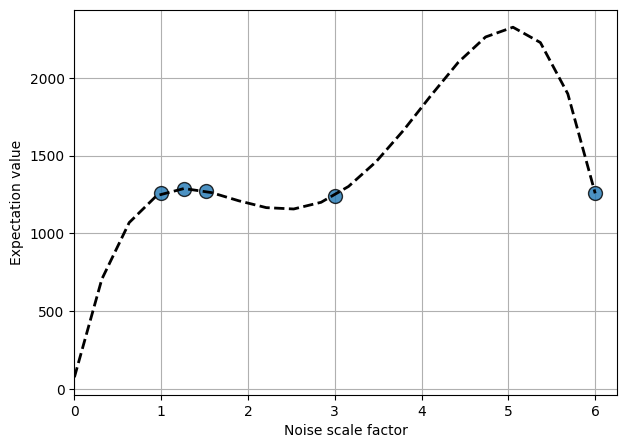

is worse
SAMPLE  1
extrapolalation: 2002.6332163931615
expectation_values: [1298.0, 1270.0, 1270.0, 1245.0, 1275.0]


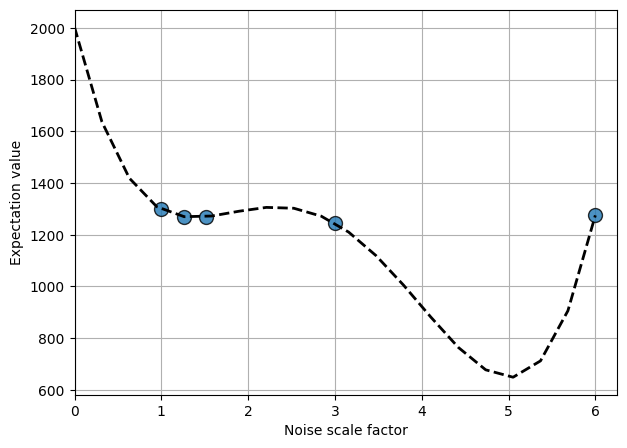

is better!
SAMPLE  2
extrapolalation: 1945.8848348777897
expectation_values: [1267.0, 1271.0, 1301.0, 1247.0, 1272.0]


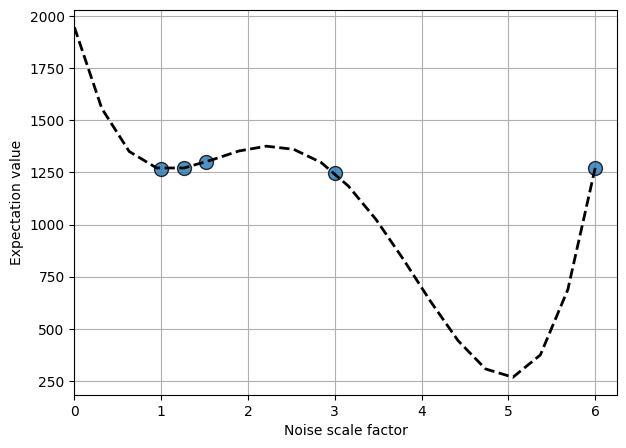

is better!
SAMPLE  3
extrapolalation: 2437.488138444458
expectation_values: [1253.0, 1211.0, 1218.0, 1242.0, 1295.0]


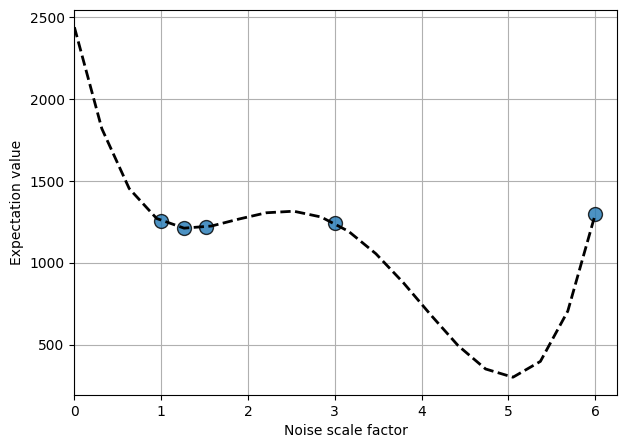

is better!
SAMPLE  4
extrapolalation: 2513.1402530069604
expectation_values: [1269.0, 1258.0, 1295.0, 1206.0, 1251.0]


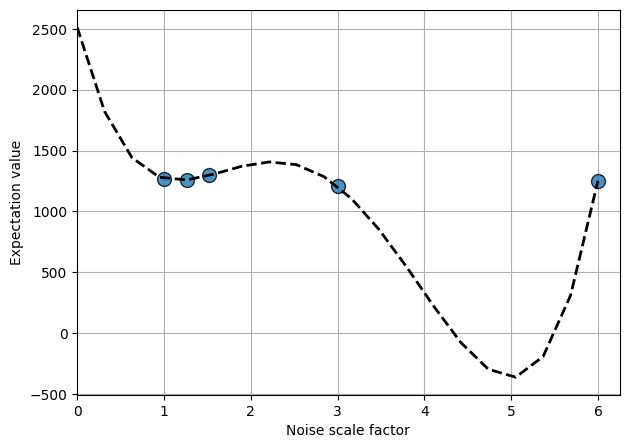

is better!
SAMPLE  5
extrapolalation: 2494.544131965642
expectation_values: [1301.0, 1269.0, 1285.0, 1261.0, 1205.0]


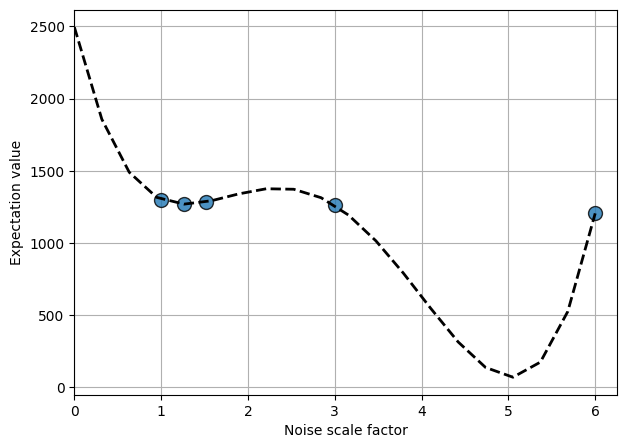

is better!
SAMPLE  6
extrapolalation: 2251.7420500736125
expectation_values: [1293.0, 1261.0, 1267.0, 1231.0, 1299.0]


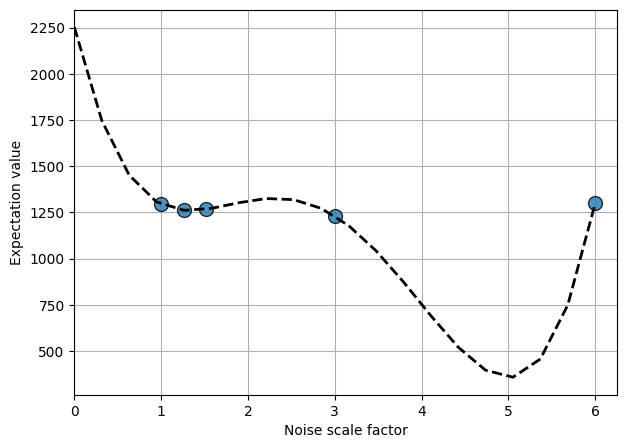

is better!
SAMPLE  7
extrapolalation: 3353.6074258552994
expectation_values: [1329.0, 1265.0, 1281.0, 1195.0, 1257.0]


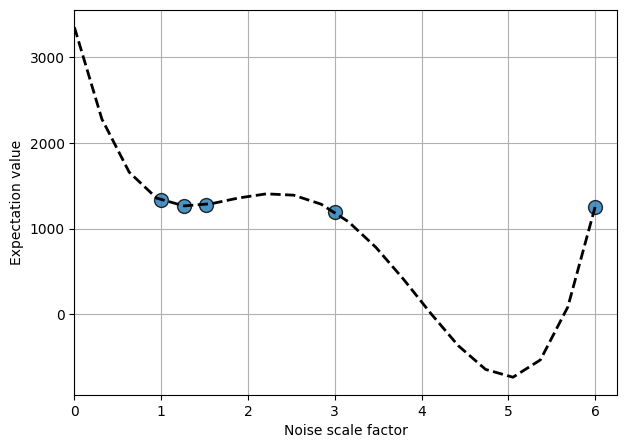

is better!
SAMPLE  8
extrapolalation: -1240.3225118432913
expectation_values: [1258.0, 1301.0, 1242.0, 1235.0, 1231.0]


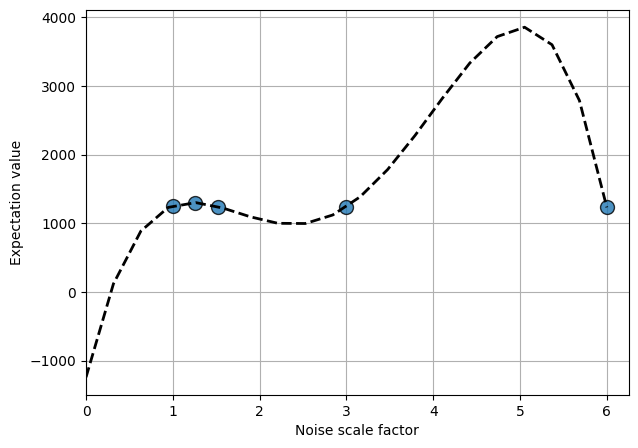

is worse
SAMPLE  9
extrapolalation: 2573.386454102417
expectation_values: [1249.0, 1248.0, 1300.0, 1270.0, 1283.0]


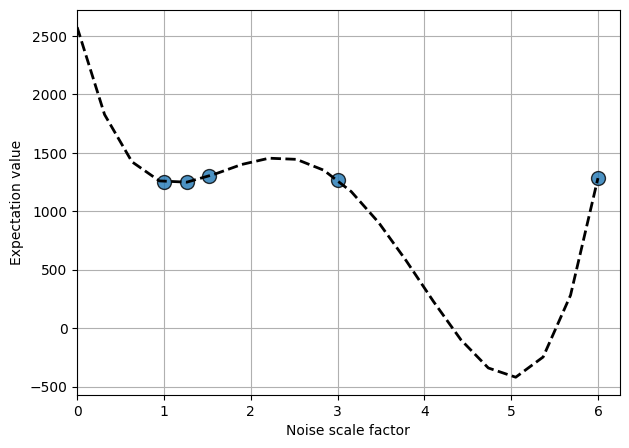

is better!
SAMPLE  10
extrapolalation: 1805.3445351958364
expectation_values: [1285.0, 1258.0, 1251.0, 1208.0, 1192.0]


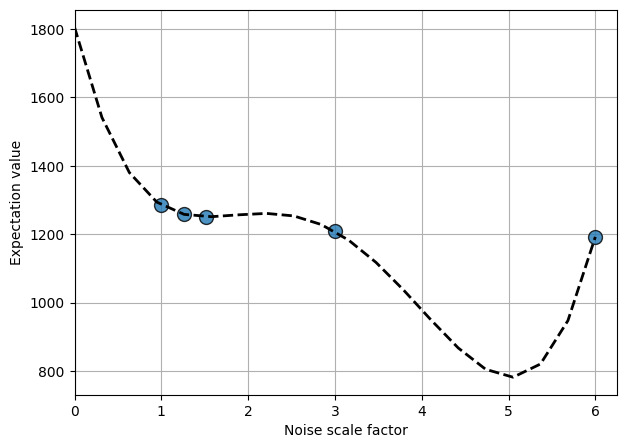

is better!
SAMPLE  11
extrapolalation: 332.10405157061825
expectation_values: [1252.0, 1273.0, 1256.0, 1239.0, 1239.0]


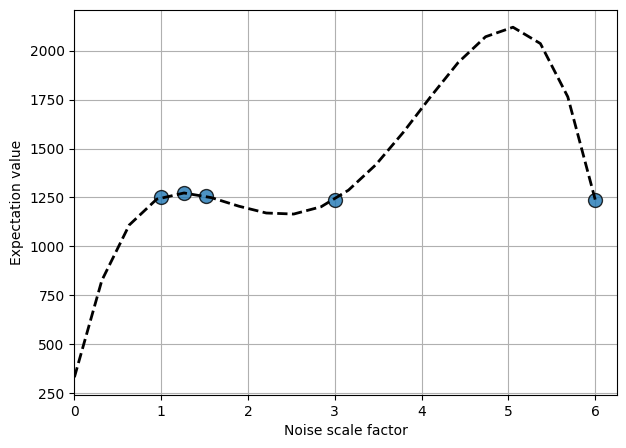

is worse
SAMPLE  12
extrapolalation: 1316.2951021187669
expectation_values: [1274.0, 1265.0, 1258.0, 1266.0, 1246.0]


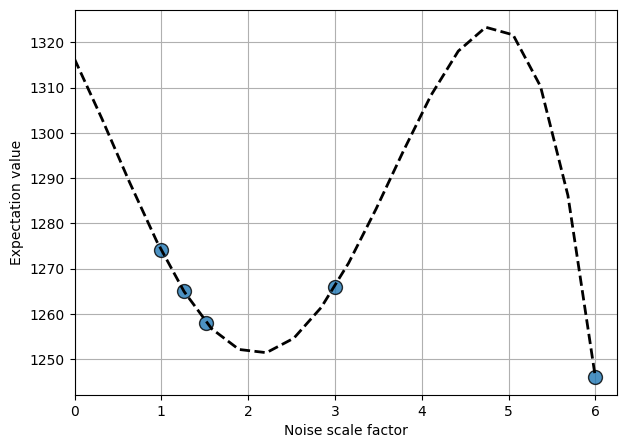

is better!
SAMPLE  13
extrapolalation: -1169.780148170874
expectation_values: [1324.0, 1324.0, 1223.0, 1239.0, 1232.0]


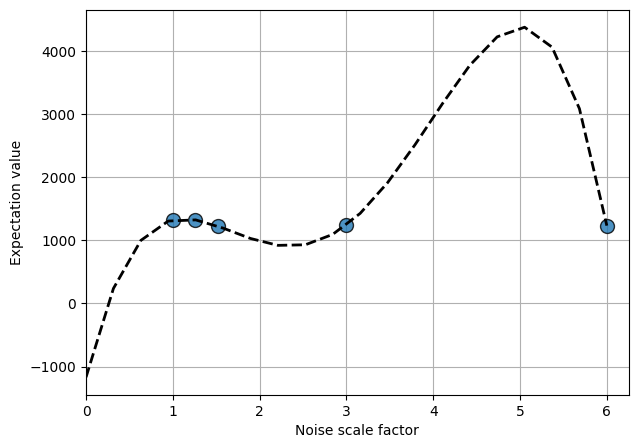

is worse
SAMPLE  14
extrapolalation: 1452.6240893188271
expectation_values: [1305.0, 1275.0, 1251.0, 1247.0, 1223.0]


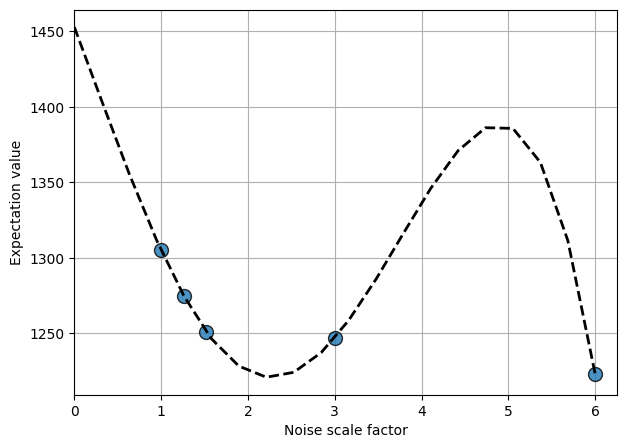

is better!
SAMPLE  15
extrapolalation: 3198.178515451189
expectation_values: [1282.0, 1242.0, 1280.0, 1277.0, 1290.0]


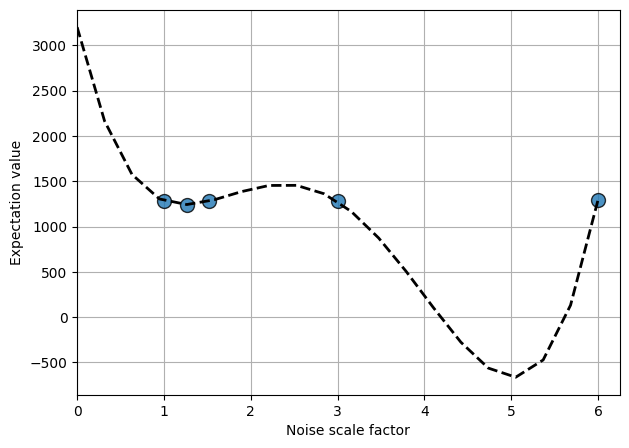

is better!
SAMPLE  16
extrapolalation: 356.7224449190339
expectation_values: [1280.0, 1302.0, 1285.0, 1239.0, 1243.0]


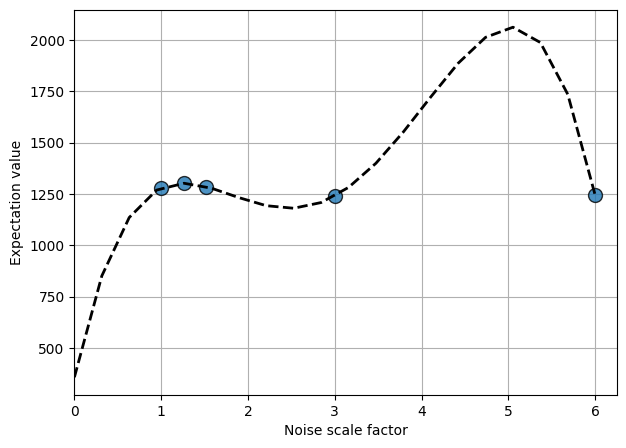

is worse
SAMPLE  17
extrapolalation: 1512.0081525931191
expectation_values: [1268.0, 1260.0, 1261.0, 1231.0, 1324.0]


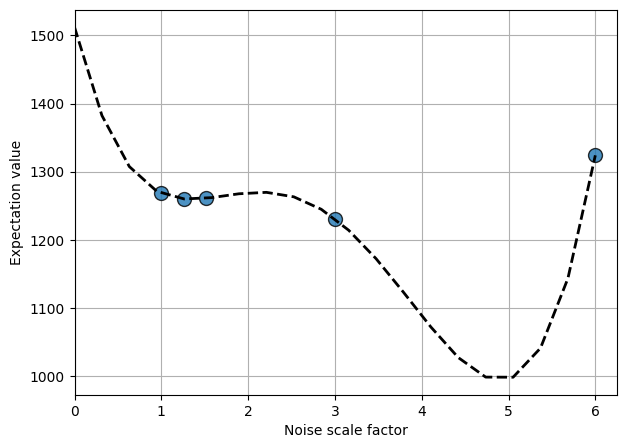

is better!
SAMPLE  18
extrapolalation: 1341.7931343945602
expectation_values: [1289.0, 1252.0, 1217.0, 1209.0, 1246.0]


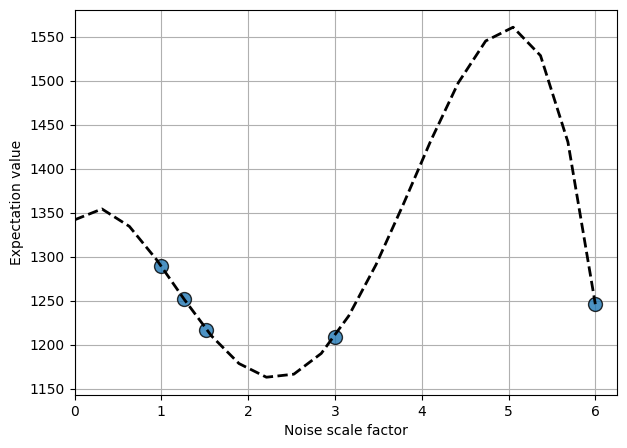

is better!
SAMPLE  19
extrapolalation: 886.1204759121906
expectation_values: [1266.0, 1219.0, 1158.0, 1203.0, 1226.0]


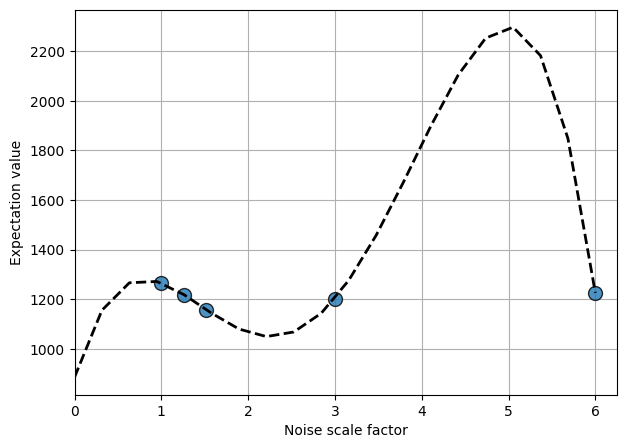

is worse
SAMPLE  20
extrapolalation: 741.7545895175836
expectation_values: [1288.0, 1284.0, 1257.0, 1232.0, 1295.0]


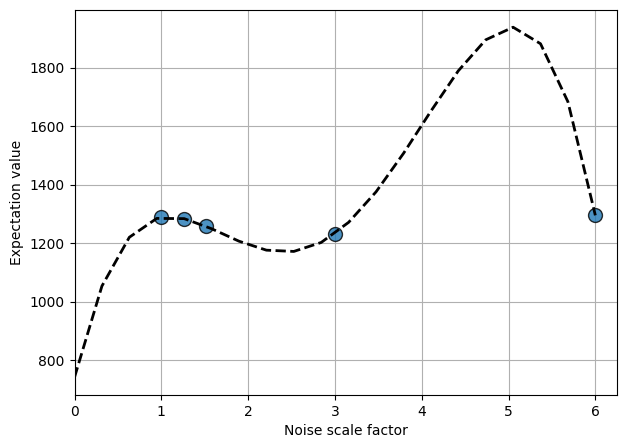

is worse
SAMPLE  21
extrapolalation: -436.4830320226122
expectation_values: [1249.0, 1309.0, 1298.0, 1223.0, 1240.0]


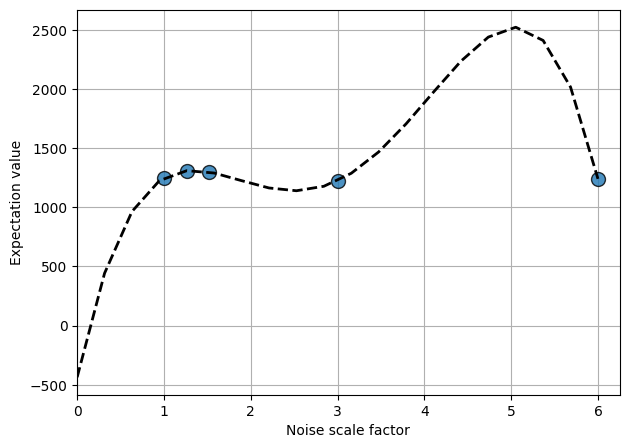

is worse
SAMPLE  22
extrapolalation: 2718.9623220838357
expectation_values: [1323.0, 1282.0, 1297.0, 1265.0, 1248.0]


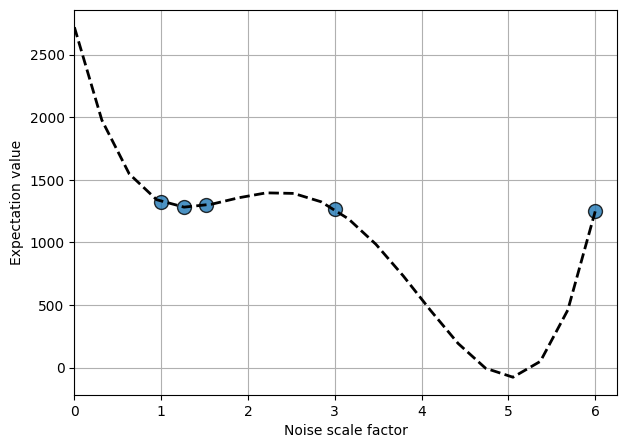

is better!
SAMPLE  23
extrapolalation: 1029.6390115563404
expectation_values: [1309.0, 1277.0, 1236.0, 1311.0, 1238.0]


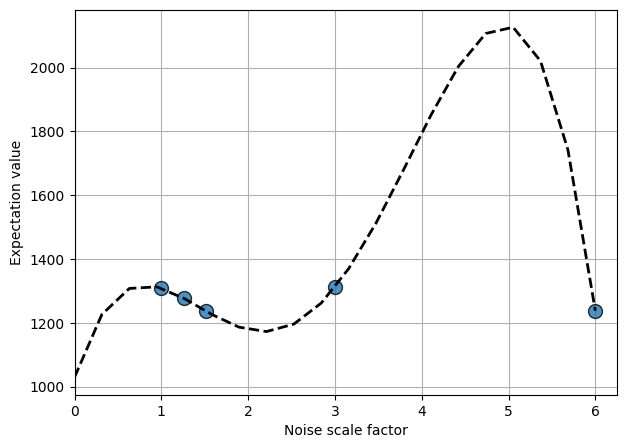

is worse
SAMPLE  24
extrapolalation: 578.1394069910843
expectation_values: [1309.0, 1255.0, 1174.0, 1259.0, 1174.0]


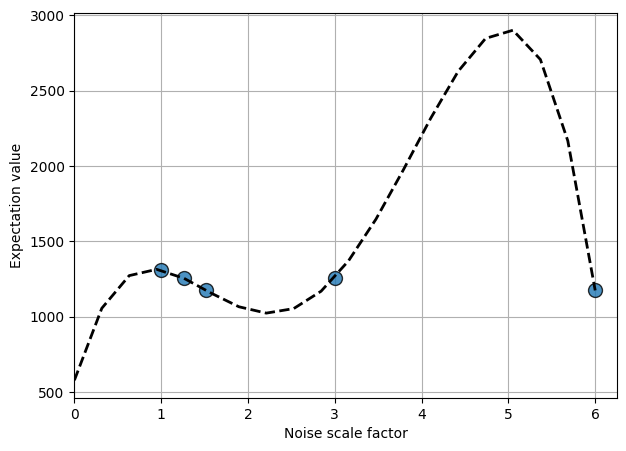

is worse
SAMPLE  25
extrapolalation: 1152.9971992753397
expectation_values: [1311.0, 1281.0, 1246.0, 1291.0, 1281.0]


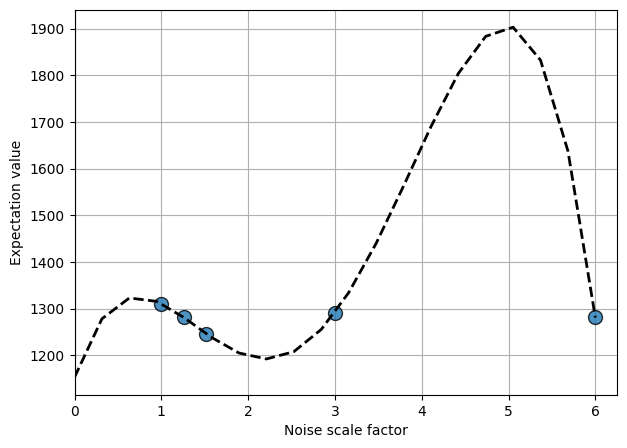

is worse
SAMPLE  26
extrapolalation: 2838.4168746921628
expectation_values: [1280.0, 1254.0, 1289.0, 1206.0, 1268.0]


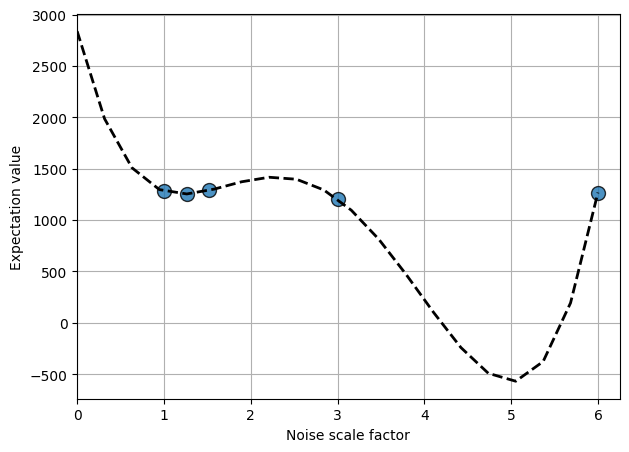

is better!
SAMPLE  27
extrapolalation: 1772.0364034028769
expectation_values: [1299.0, 1267.0, 1255.0, 1275.0, 1192.0]


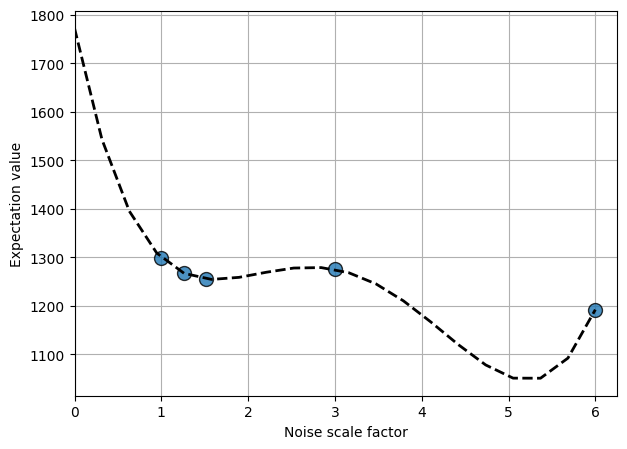

is better!
SAMPLE  28
extrapolalation: 1645.3230784360858
expectation_values: [1291.0, 1225.0, 1177.0, 1290.0, 1236.0]


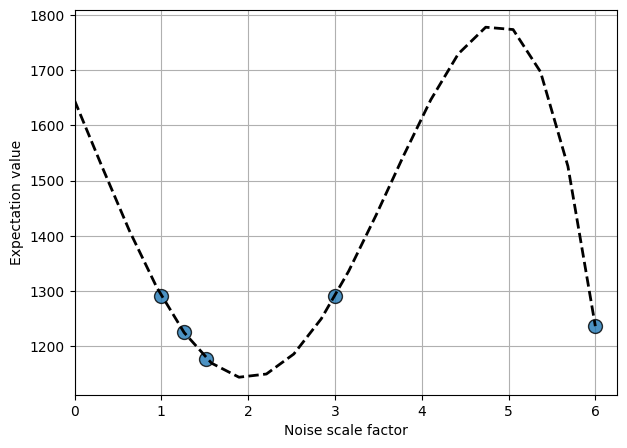

is better!
SAMPLE  29
extrapolalation: 4751.446807388842
expectation_values: [1295.0, 1218.0, 1281.0, 1251.0, 1257.0]


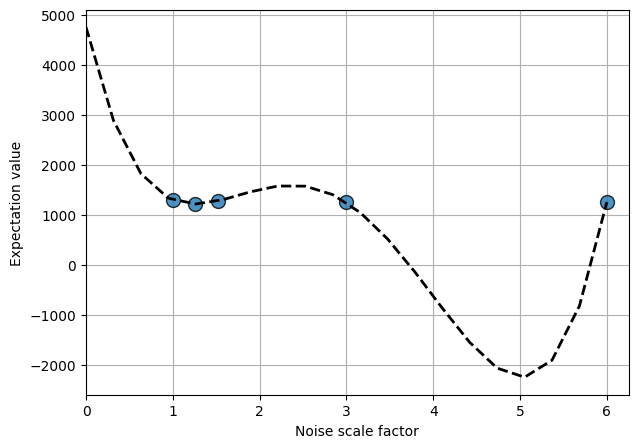

is better!
SAMPLE  30
extrapolalation: -1314.781405104049
expectation_values: [1318.0, 1301.0, 1179.0, 1249.0, 1230.0]


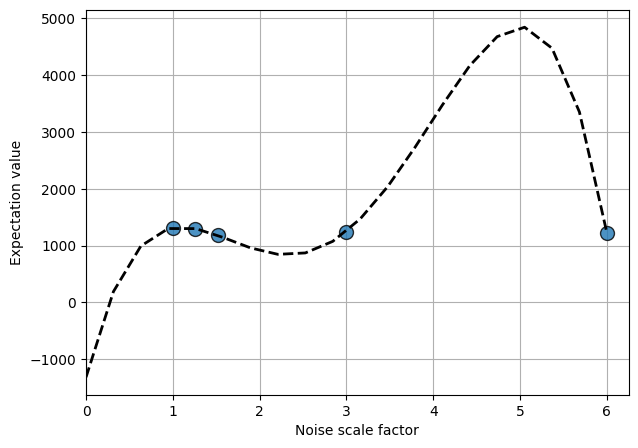

is worse
SAMPLE  31
extrapolalation: 1717.8153612412616
expectation_values: [1249.0, 1249.0, 1267.0, 1230.0, 1209.0]


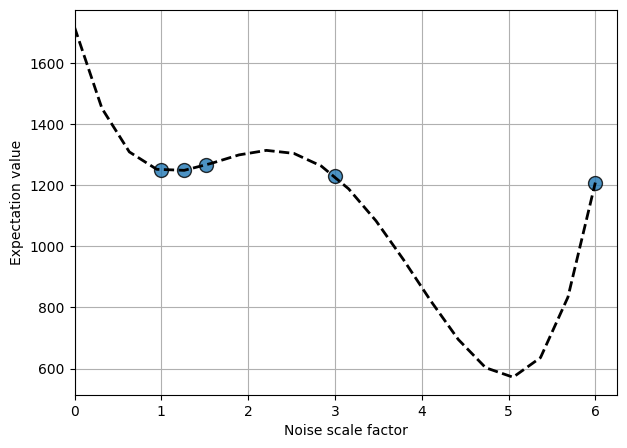

is better!
SAMPLE  32
extrapolalation: 3023.809189572578
expectation_values: [1318.0, 1235.0, 1222.0, 1233.0, 1228.0]


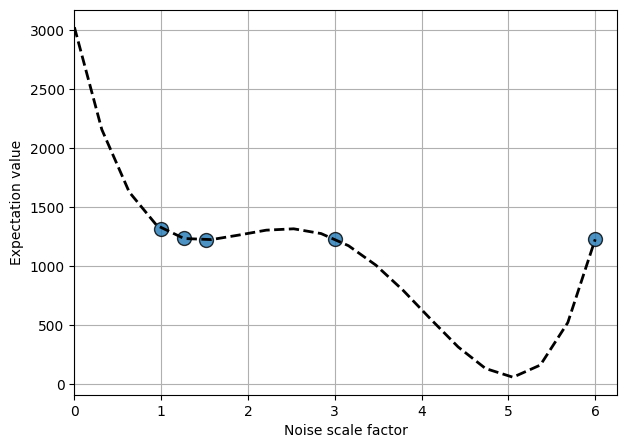

is better!
SAMPLE  33
extrapolalation: 2150.185251988776
expectation_values: [1304.0, 1275.0, 1279.0, 1229.0, 1293.0]


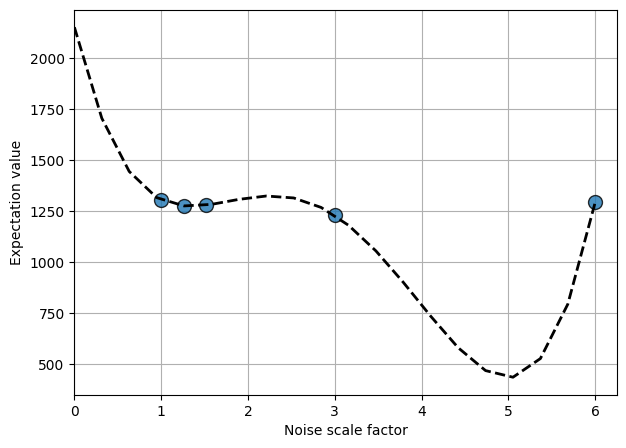

is better!
SAMPLE  34
extrapolalation: 4573.484861253889
expectation_values: [1293.0, 1216.0, 1272.0, 1248.0, 1277.0]


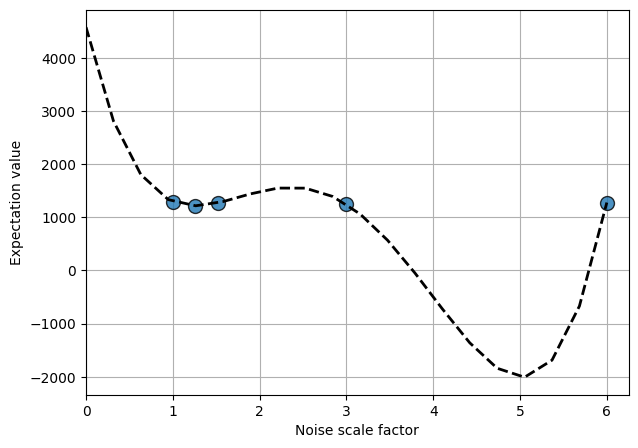

is better!
SAMPLE  35
extrapolalation: 5619.743506153764
expectation_values: [1321.0, 1193.0, 1241.0, 1263.0, 1227.0]


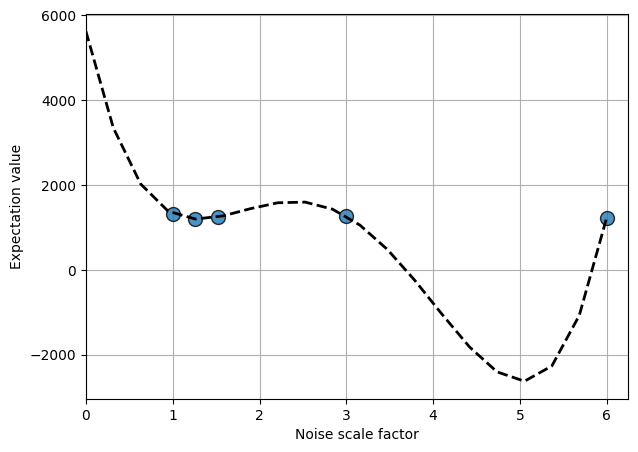

is better!
SAMPLE  36
extrapolalation: 1006.663302292271
expectation_values: [1287.0, 1265.0, 1233.0, 1278.0, 1264.0]


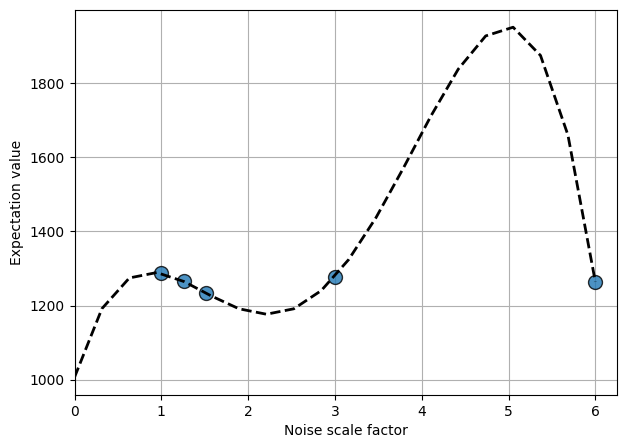

is worse
SAMPLE  37
extrapolalation: 928.7441721120371
expectation_values: [1271.0, 1270.0, 1255.0, 1253.0, 1276.0]


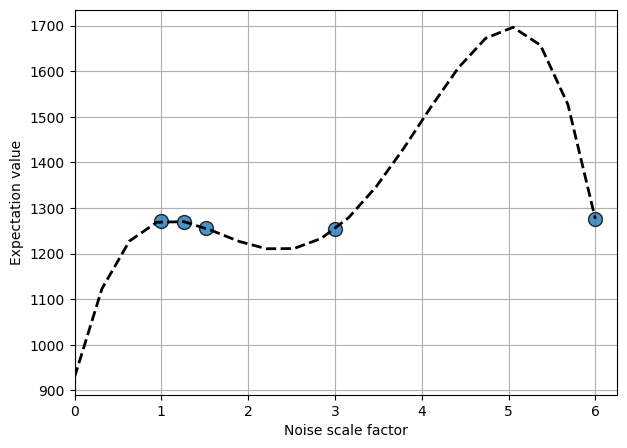

is worse
SAMPLE  38
extrapolalation: 3535.1574307451533
expectation_values: [1254.0, 1189.0, 1218.0, 1251.0, 1254.0]


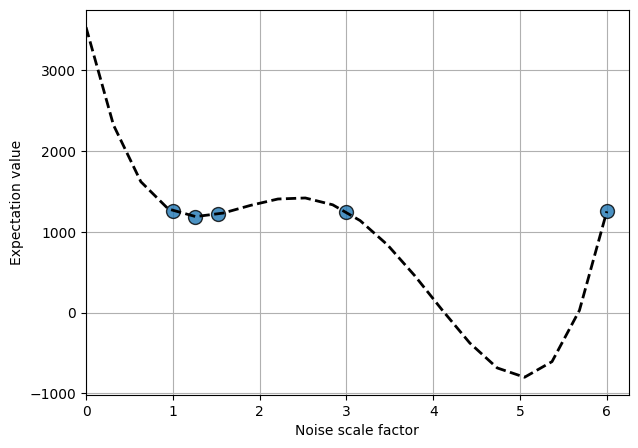

is better!
SAMPLE  39
extrapolalation: -115.65740871813892
expectation_values: [1285.0, 1283.0, 1224.0, 1224.0, 1238.0]


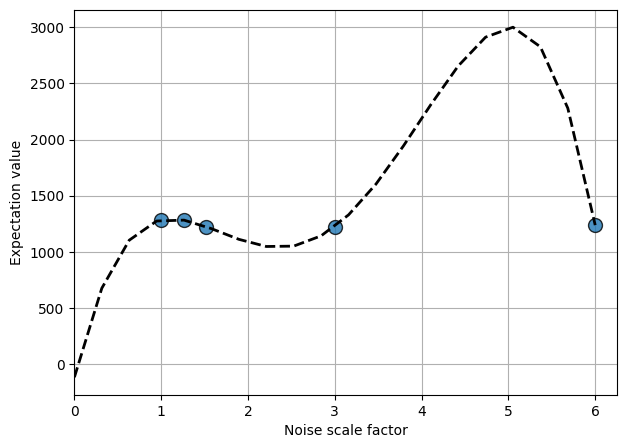

is worse
SAMPLE  40
extrapolalation: 2300.5046575776423
expectation_values: [1303.0, 1258.0, 1255.0, 1295.0, 1175.0]


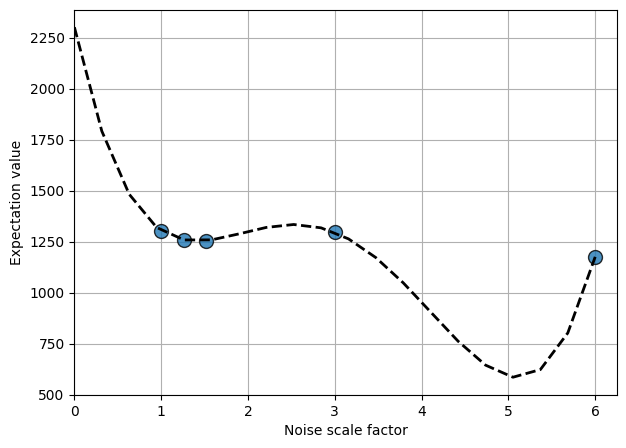

is better!
SAMPLE  41
extrapolalation: 2496.241982671675
expectation_values: [1271.0, 1241.0, 1262.0, 1296.0, 1235.0]


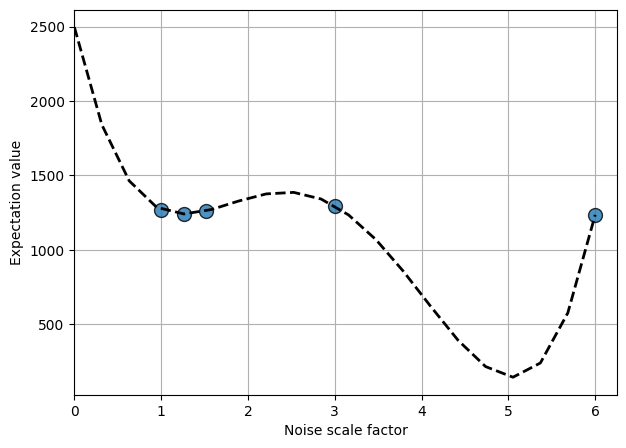

is better!
SAMPLE  42
extrapolalation: 2682.127997112399
expectation_values: [1277.0, 1210.0, 1201.0, 1223.0, 1272.0]


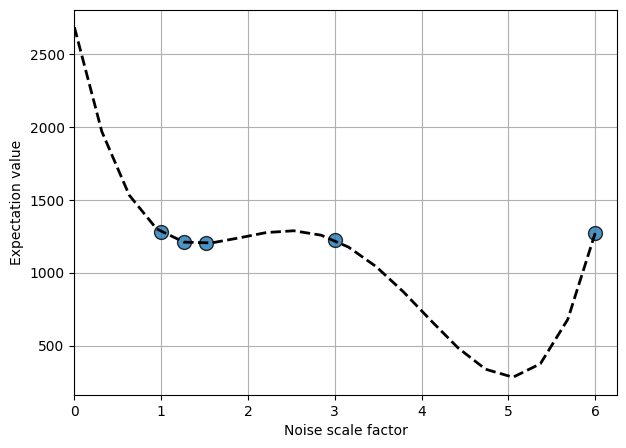

is better!
SAMPLE  43
extrapolalation: 2053.611644572171
expectation_values: [1268.0, 1231.0, 1226.0, 1223.0, 1216.0]


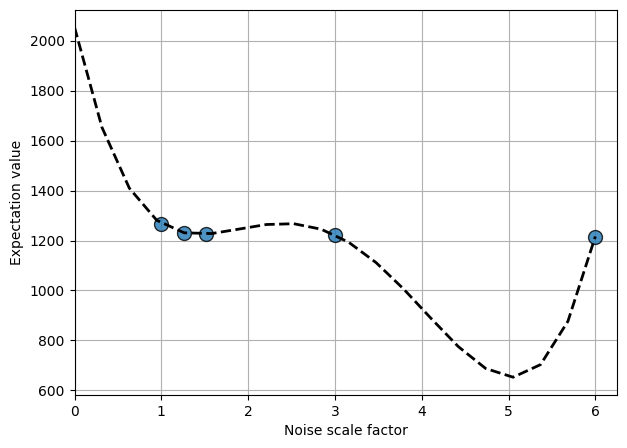

is better!
SAMPLE  44
extrapolalation: 144.61177275312448
expectation_values: [1258.0, 1264.0, 1226.0, 1270.0, 1235.0]


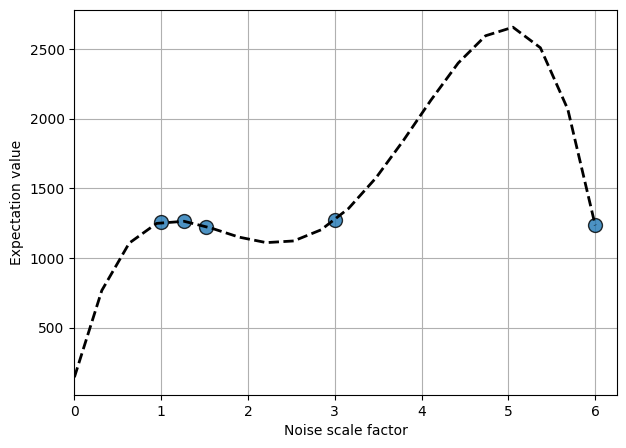

is worse
SAMPLE  45
extrapolalation: -903.5426818264142
expectation_values: [1262.0, 1292.0, 1234.0, 1242.0, 1272.0]


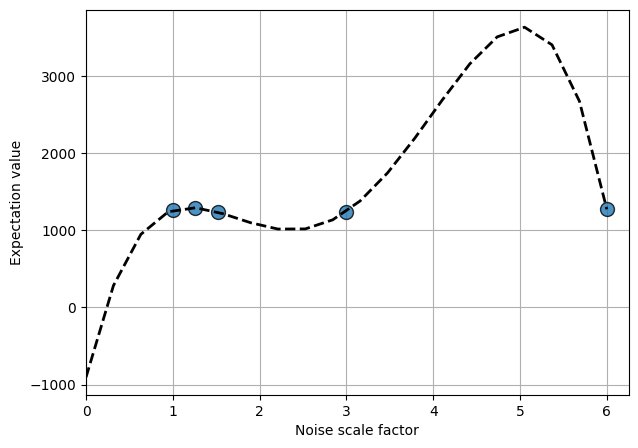

is worse
SAMPLE  46
extrapolalation: -850.0687109928645
expectation_values: [1289.0, 1308.0, 1240.0, 1244.0, 1265.0]


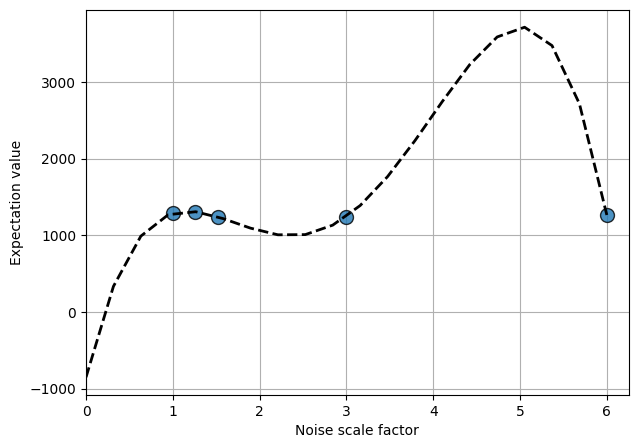

is worse
SAMPLE  47
extrapolalation: 3345.0082251294975
expectation_values: [1263.0, 1236.0, 1291.0, 1198.0, 1279.0]


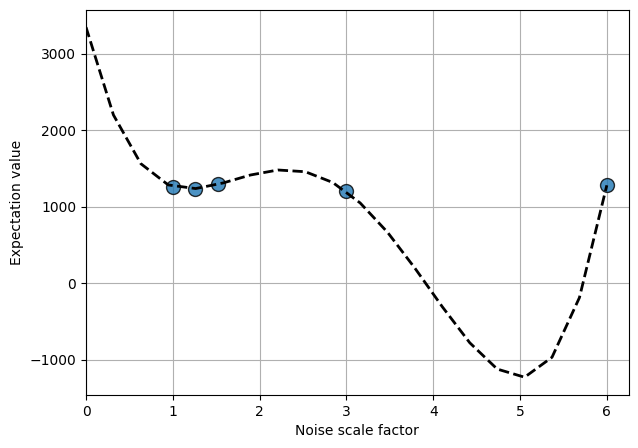

is better!
SAMPLE  48
extrapolalation: 2913.0844682602915
expectation_values: [1327.0, 1271.0, 1278.0, 1220.0, 1224.0]


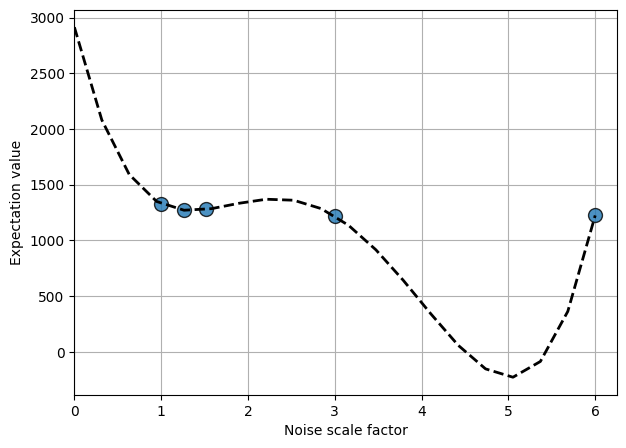

is better!
SAMPLE  49
extrapolalation: 3642.962685748769
expectation_values: [1279.0, 1252.0, 1318.0, 1208.0, 1250.0]


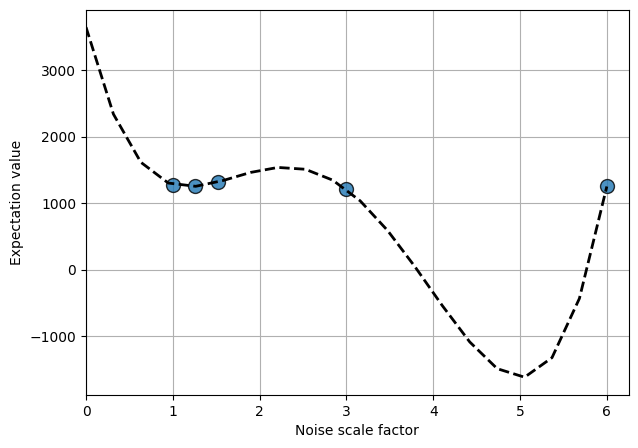

is better!
SAMPLE  50
extrapolalation: 1927.0608947391258
expectation_values: [1315.0, 1276.0, 1262.0, 1260.0, 1217.0]


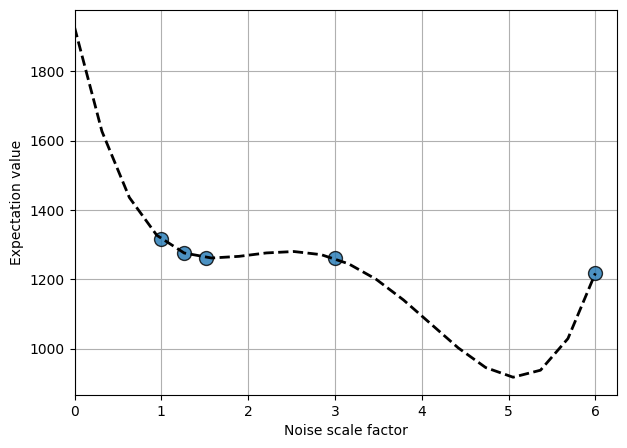

is better!
SAMPLE  51
extrapolalation: 2288.20356036186
expectation_values: [1271.0, 1247.0, 1265.0, 1283.0, 1281.0]


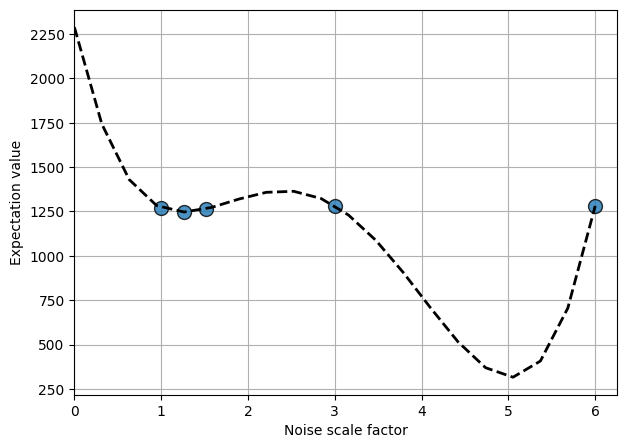

is better!
SAMPLE  52
extrapolalation: 3933.6606181476313
expectation_values: [1259.0, 1222.0, 1292.0, 1227.0, 1273.0]


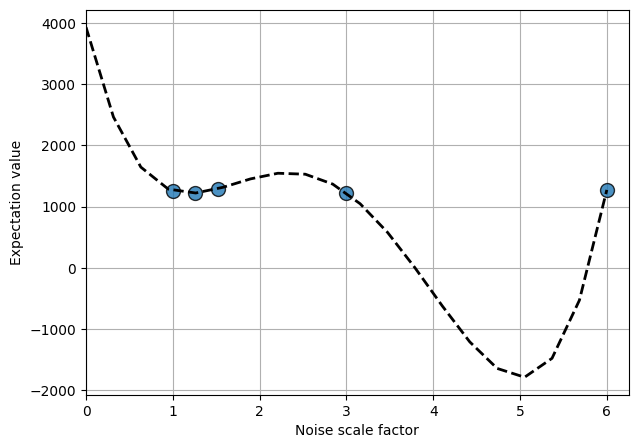

is better!
SAMPLE  53
extrapolalation: -466.46847036454005
expectation_values: [1311.0, 1295.0, 1208.0, 1252.0, 1279.0]


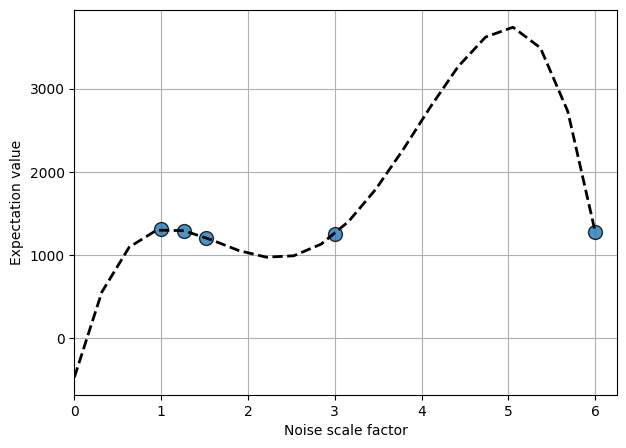

is worse
SAMPLE  54
extrapolalation: 5186.372378357043
expectation_values: [1324.0, 1210.0, 1252.0, 1202.0, 1266.0]


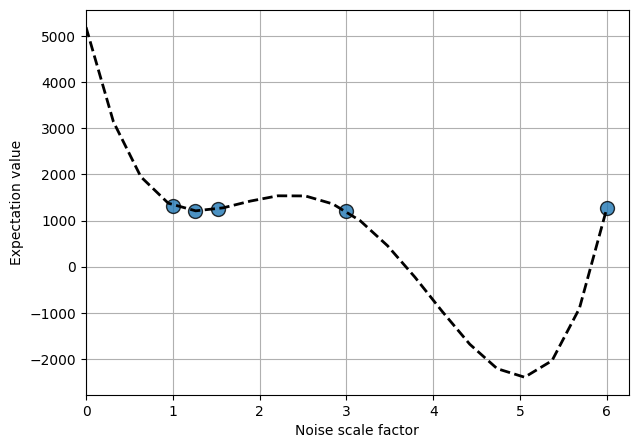

is better!
SAMPLE  55
extrapolalation: 1783.2307221263593
expectation_values: [1369.0, 1295.0, 1239.0, 1269.0, 1231.0]


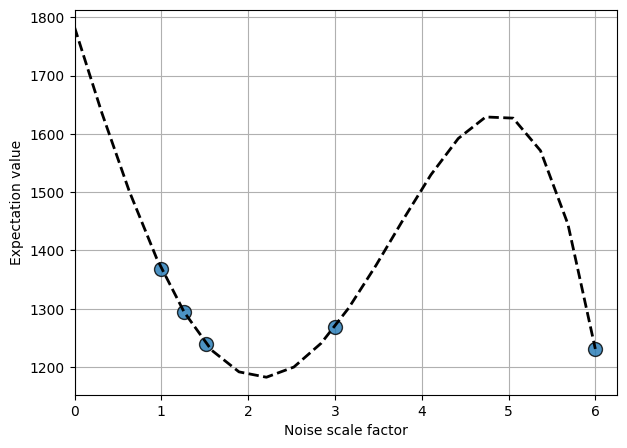

is better!
SAMPLE  56
extrapolalation: 6889.810210890025
expectation_values: [1299.0, 1216.0, 1358.0, 1264.0, 1244.0]


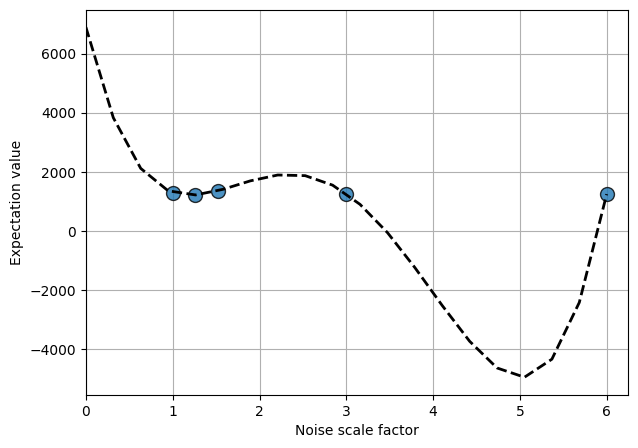

is better!
SAMPLE  57
extrapolalation: 3121.6200098036875
expectation_values: [1239.0, 1223.0, 1283.0, 1260.0, 1231.0]


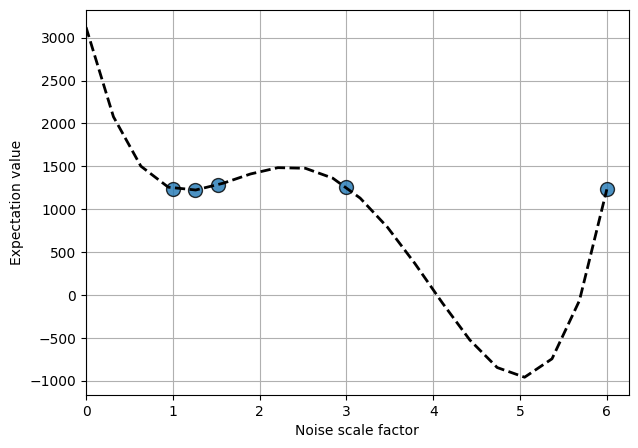

is better!
SAMPLE  58
extrapolalation: 460.6298101659036
expectation_values: [1322.0, 1326.0, 1292.0, 1194.0, 1252.0]


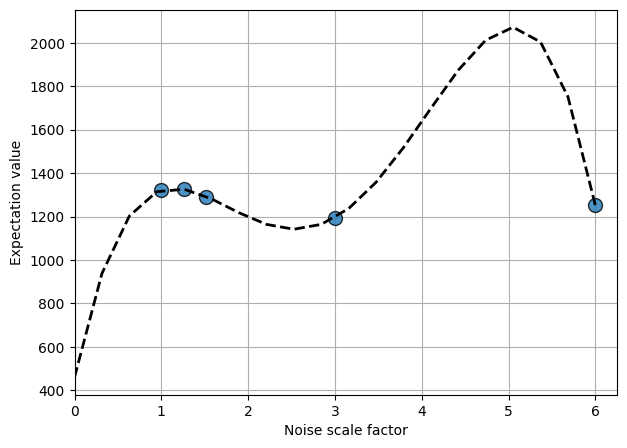

is worse
SAMPLE  59
extrapolalation: 3985.5262037001394
expectation_values: [1327.0, 1235.0, 1252.0, 1270.0, 1269.0]


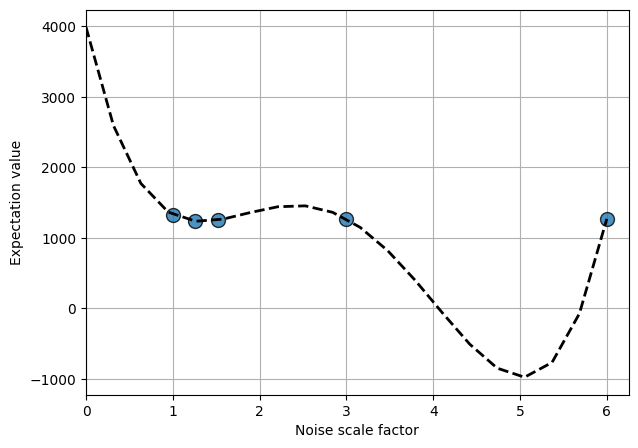

is better!
SAMPLE  60
extrapolalation: 3720.326082577982
expectation_values: [1310.0, 1248.0, 1284.0, 1275.0, 1287.0]


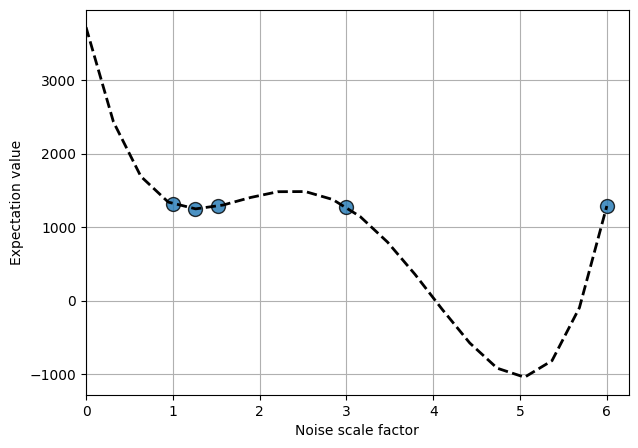

is better!
SAMPLE  61
extrapolalation: -519.9497177280846
expectation_values: [1285.0, 1290.0, 1223.0, 1272.0, 1250.0]


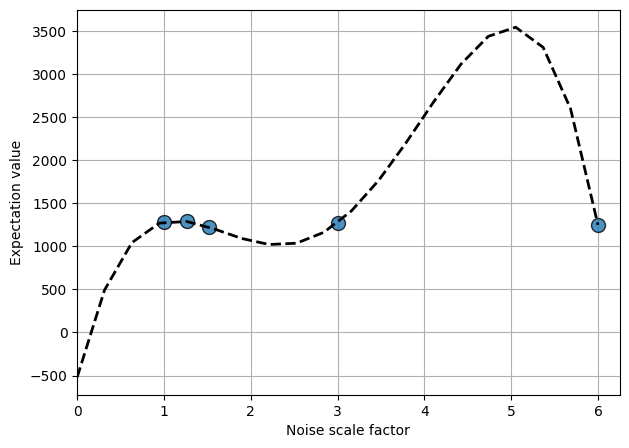

is worse
SAMPLE  62
extrapolalation: 2747.231610026814
expectation_values: [1292.0, 1232.0, 1232.0, 1253.0, 1285.0]


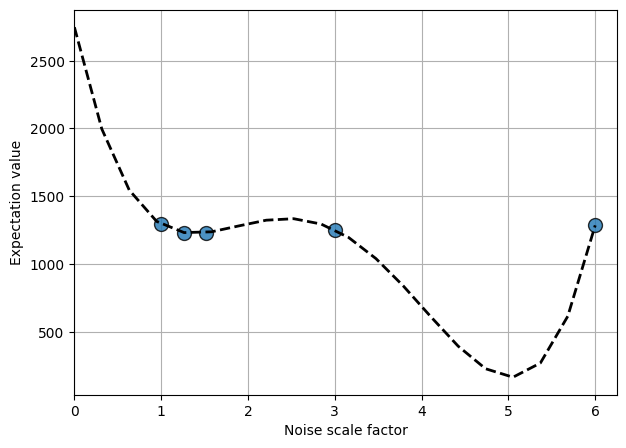

is better!
SAMPLE  63
extrapolalation: 1477.9262468741683
expectation_values: [1325.0, 1267.0, 1216.0, 1237.0, 1269.0]


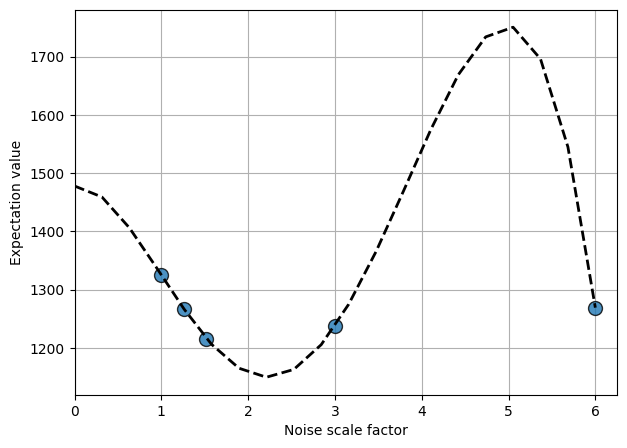

is better!
SAMPLE  64
extrapolalation: 2706.9854501896125
expectation_values: [1331.0, 1251.0, 1229.0, 1288.0, 1265.0]


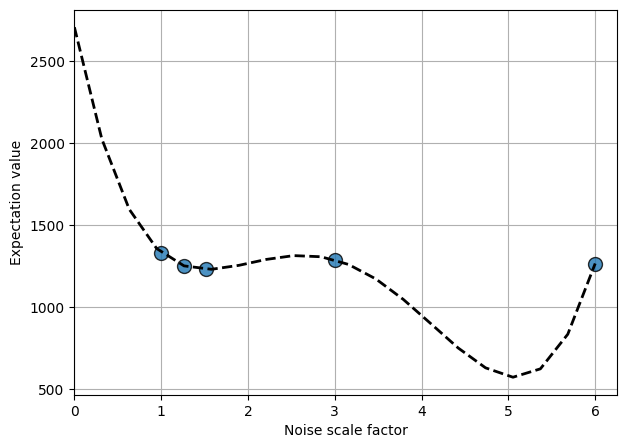

is better!
SAMPLE  65
extrapolalation: 3703.529913735988
expectation_values: [1282.0, 1227.0, 1270.0, 1246.0, 1246.0]


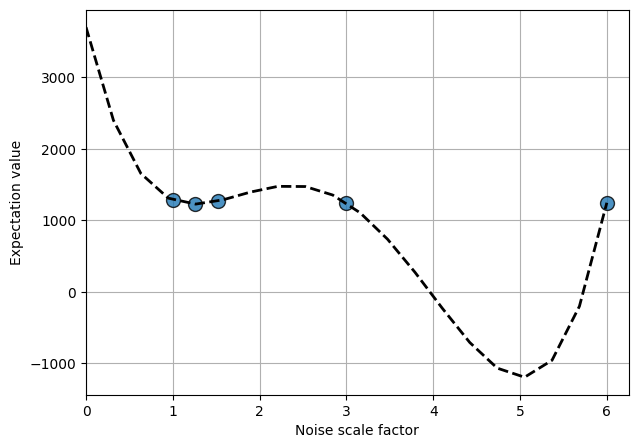

is better!
SAMPLE  66
extrapolalation: 5354.862118415909
expectation_values: [1315.0, 1245.0, 1336.0, 1215.0, 1264.0]


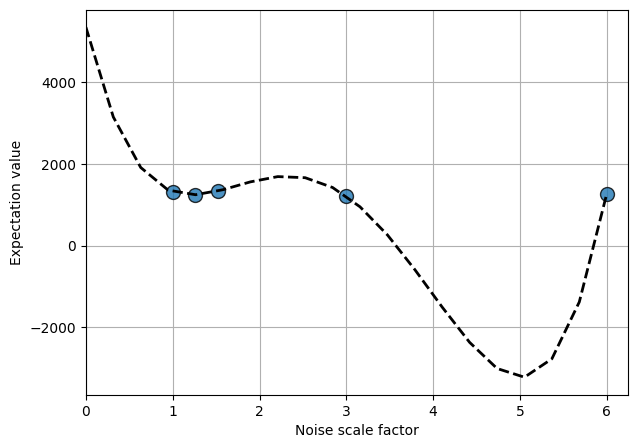

is better!
SAMPLE  67
extrapolalation: 1317.5234493815428
expectation_values: [1309.0, 1287.0, 1266.0, 1286.0, 1294.0]


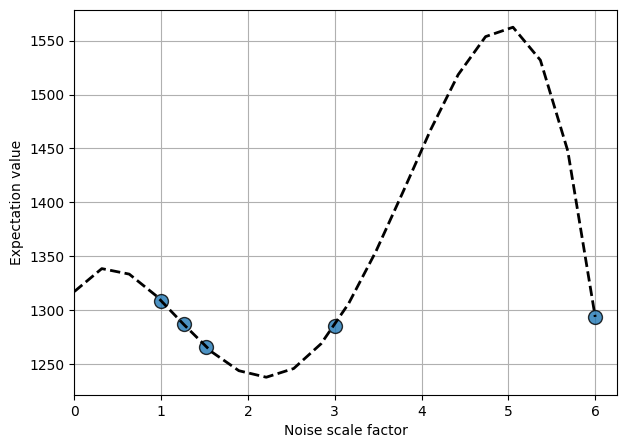

is better!
SAMPLE  68
extrapolalation: 1044.4372194720067
expectation_values: [1291.0, 1269.0, 1238.0, 1270.0, 1243.0]


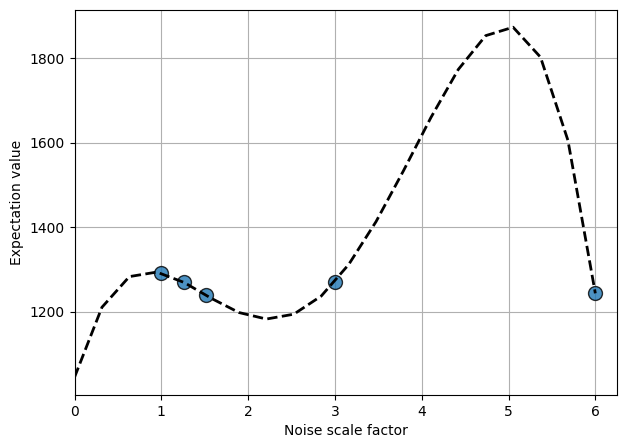

is worse
SAMPLE  69
extrapolalation: -375.86417580604007
expectation_values: [1250.0, 1300.0, 1283.0, 1260.0, 1267.0]


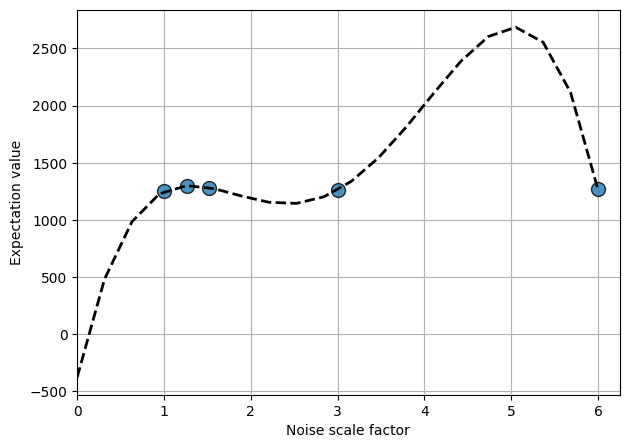

is worse
SAMPLE  70
extrapolalation: 1541.0558333484296
expectation_values: [1311.0, 1324.0, 1343.0, 1232.0, 1291.0]


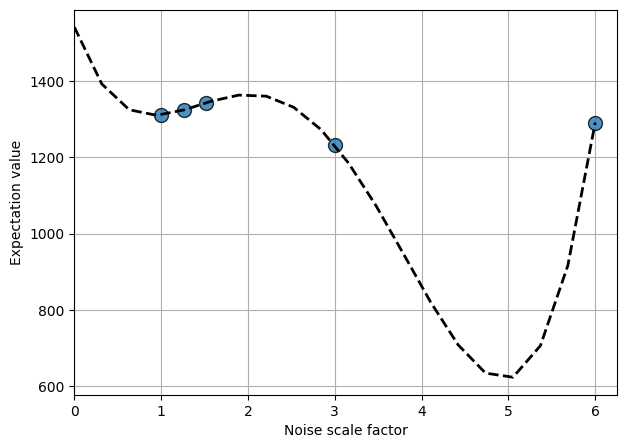

is better!
SAMPLE  71
extrapolalation: 496.7840893934619
expectation_values: [1196.0, 1227.0, 1230.0, 1248.0, 1224.0]


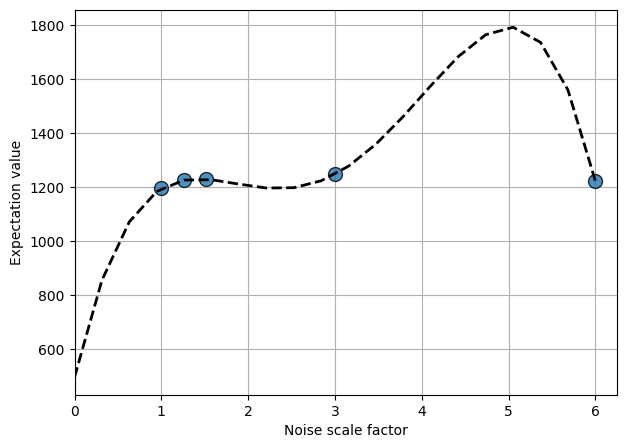

is worse
SAMPLE  72
extrapolalation: 1845.302014186432
expectation_values: [1274.0, 1238.0, 1228.0, 1316.0, 1259.0]


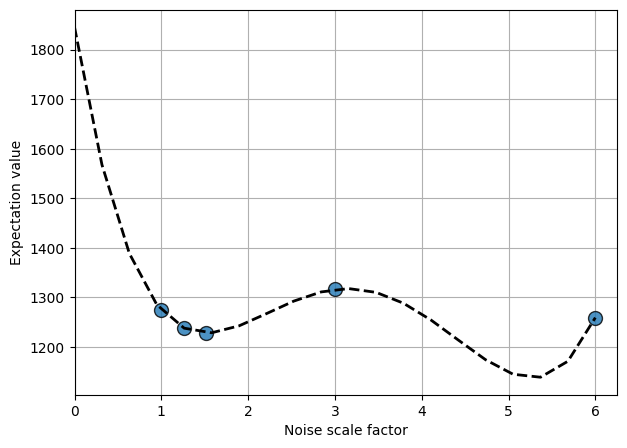

is better!
SAMPLE  73
extrapolalation: -1644.0551319779076
expectation_values: [1285.0, 1325.0, 1245.0, 1223.0, 1272.0]


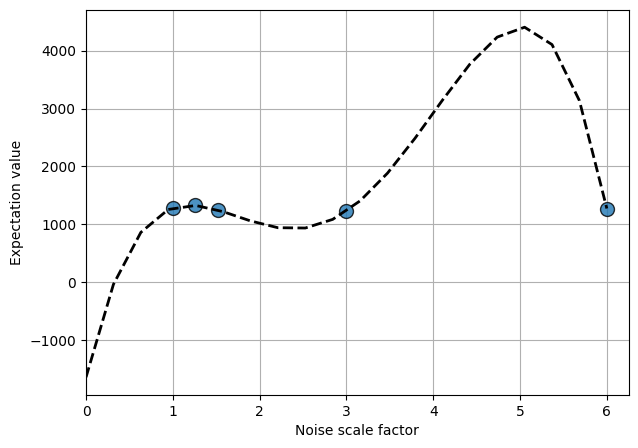

is worse
SAMPLE  74
extrapolalation: 1278.4391810359068
expectation_values: [1280.0, 1245.0, 1213.0, 1310.0, 1187.0]


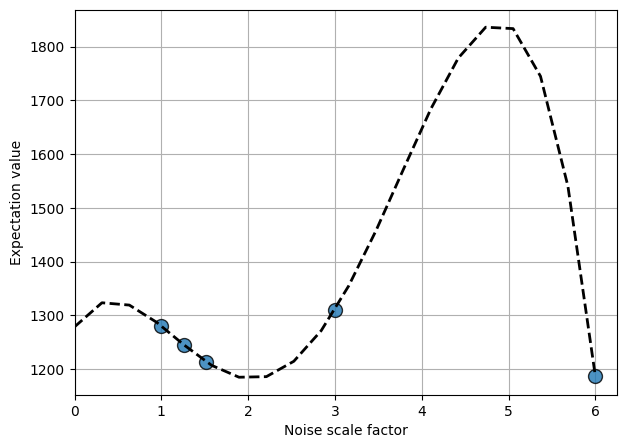

is worse
SAMPLE  75
extrapolalation: 3584.615652525489
expectation_values: [1260.0, 1210.0, 1255.0, 1265.0, 1326.0]


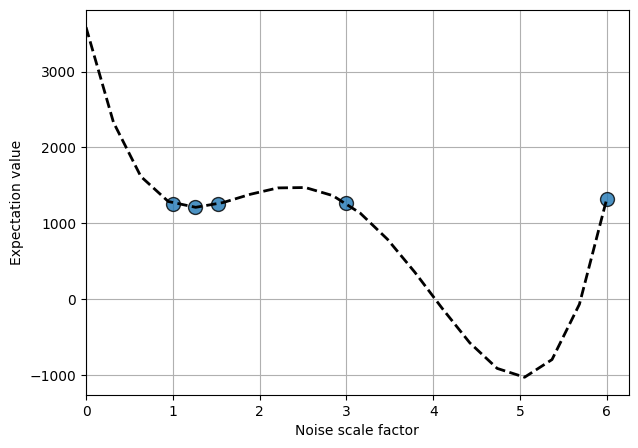

is better!
SAMPLE  76
extrapolalation: -171.30852432234929
expectation_values: [1264.0, 1279.0, 1236.0, 1252.0, 1279.0]


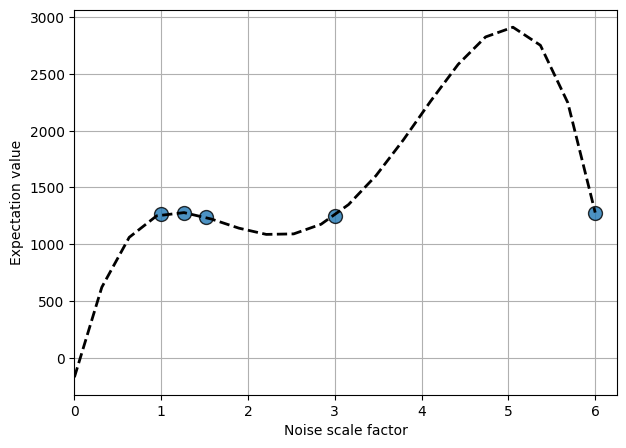

is worse
SAMPLE  77
extrapolalation: 4240.582397484948
expectation_values: [1302.0, 1233.0, 1282.0, 1222.0, 1250.0]


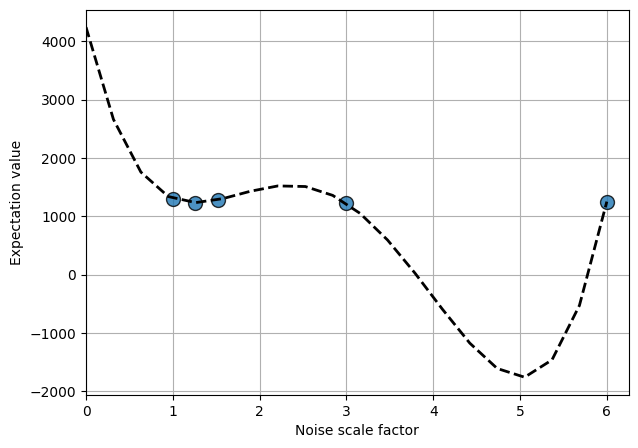

is better!
SAMPLE  78
extrapolalation: 1655.7857879794271
expectation_values: [1214.0, 1252.0, 1306.0, 1242.0, 1200.0]


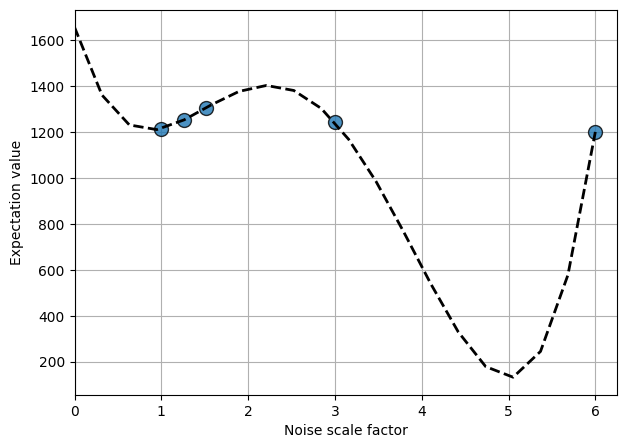

is better!
SAMPLE  79
extrapolalation: 2503.2312826378993
expectation_values: [1304.0, 1258.0, 1261.0, 1262.0, 1224.0]


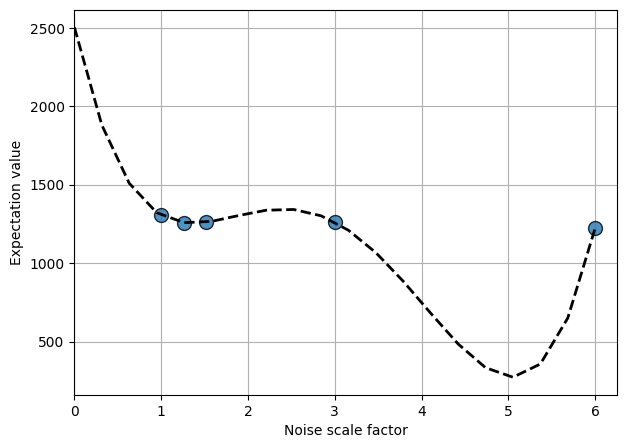

is better!
SAMPLE  80
extrapolalation: 4334.034644881082
expectation_values: [1322.0, 1235.0, 1269.0, 1208.0, 1257.0]


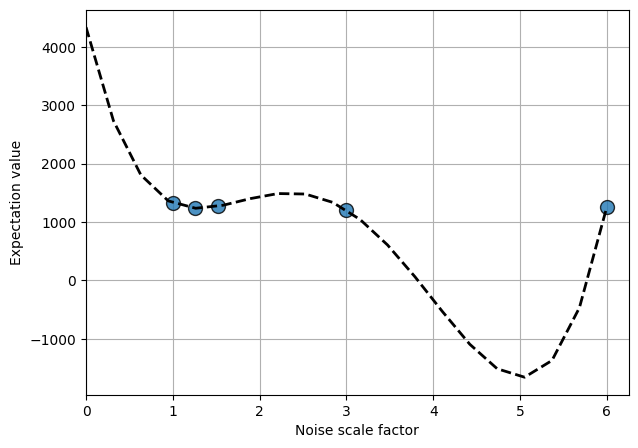

is better!
SAMPLE  81
extrapolalation: -435.56806189020864
expectation_values: [1337.0, 1295.0, 1184.0, 1284.0, 1221.0]


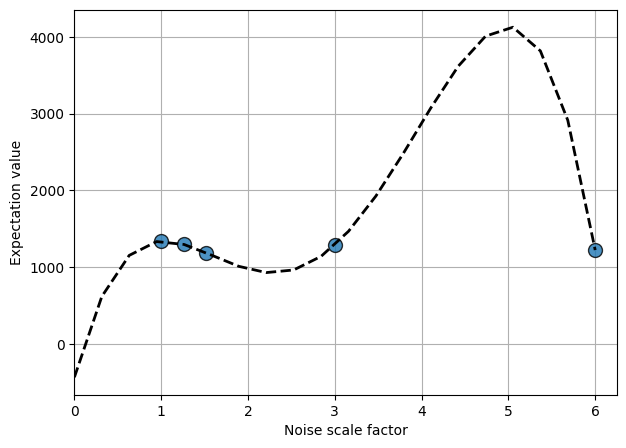

is worse
SAMPLE  82
extrapolalation: 1796.422718889816
expectation_values: [1286.0, 1249.0, 1233.0, 1238.0, 1283.0]


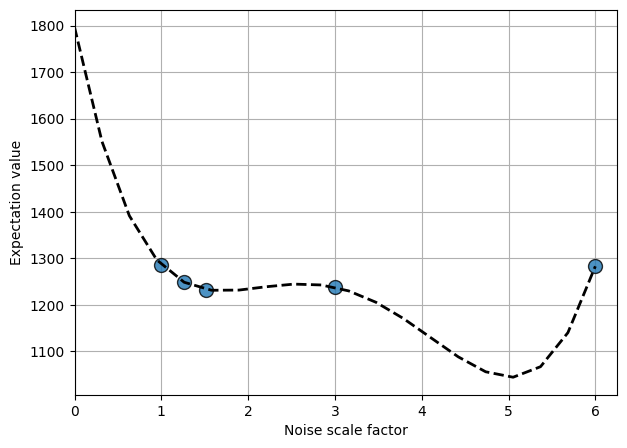

is better!
SAMPLE  83
extrapolalation: 3798.789041991695
expectation_values: [1363.0, 1282.0, 1297.0, 1184.0, 1229.0]


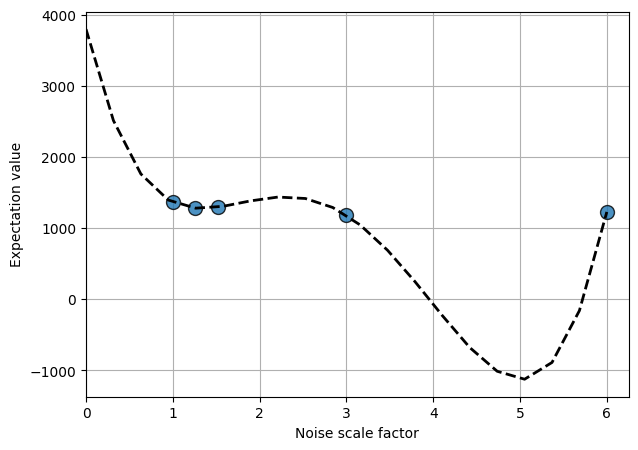

is better!
SAMPLE  84
extrapolalation: 3732.721701906384
expectation_values: [1294.0, 1218.0, 1242.0, 1260.0, 1267.0]


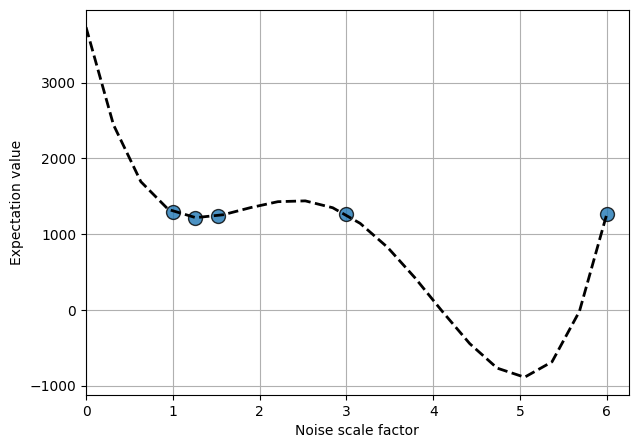

is better!
SAMPLE  85
extrapolalation: 1738.4267563896292
expectation_values: [1315.0, 1281.0, 1263.0, 1219.0, 1269.0]


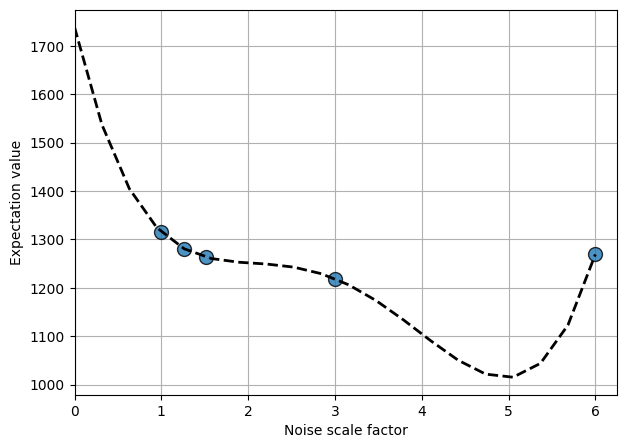

is better!
SAMPLE  86
extrapolalation: -438.50073002608417
expectation_values: [1271.0, 1273.0, 1205.0, 1191.0, 1214.0]


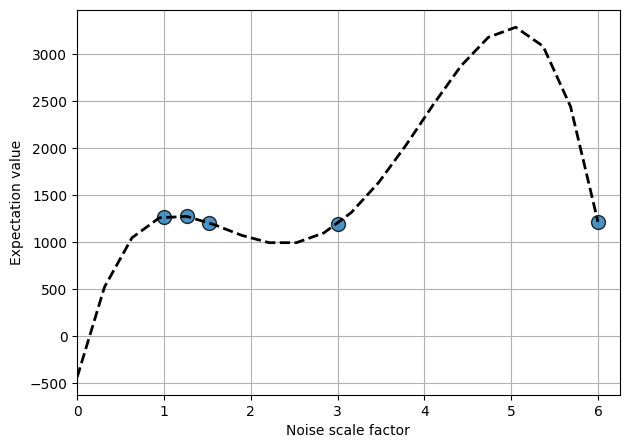

is worse
SAMPLE  87
extrapolalation: 1800.862902568075
expectation_values: [1276.0, 1265.0, 1273.0, 1195.0, 1316.0]


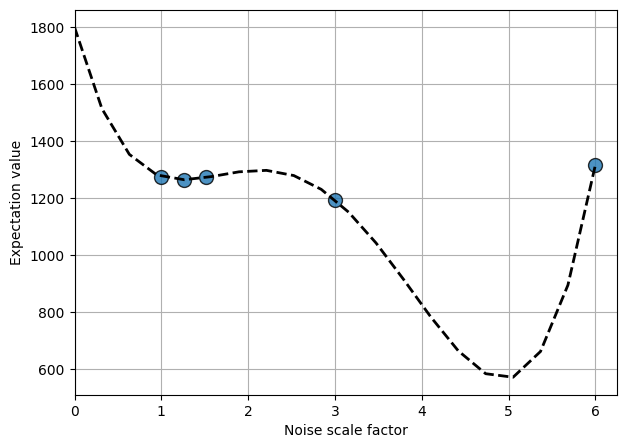

is better!
SAMPLE  88
extrapolalation: 2209.301334134051
expectation_values: [1266.0, 1214.0, 1203.0, 1286.0, 1283.0]


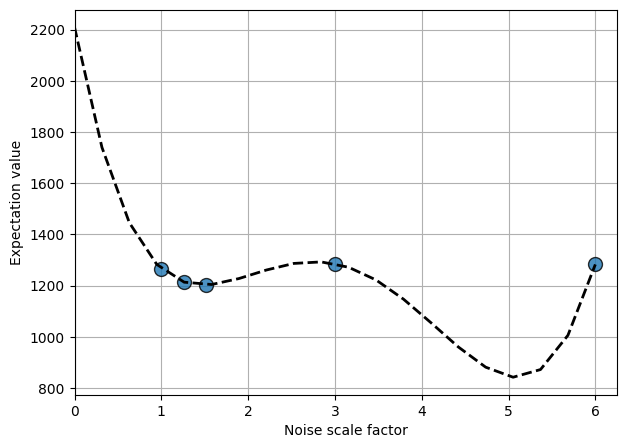

is better!
SAMPLE  89
extrapolalation: 3902.432963018802
expectation_values: [1237.0, 1205.0, 1280.0, 1227.0, 1223.0]


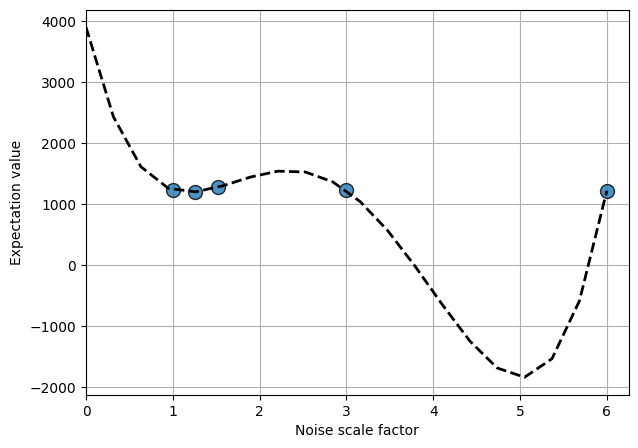

is better!
SAMPLE  90
extrapolalation: 1827.3315750229635
expectation_values: [1294.0, 1249.0, 1227.0, 1266.0, 1258.0]


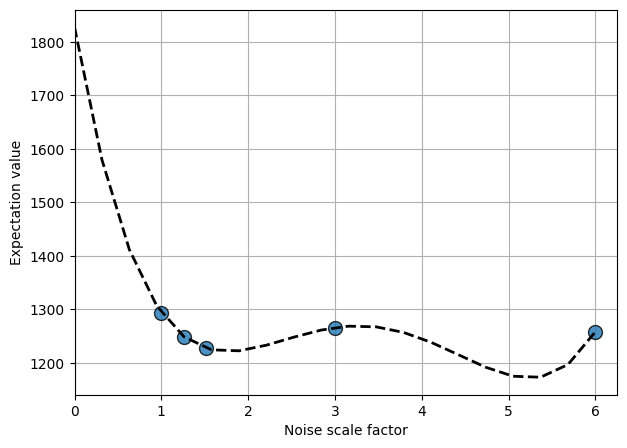

is better!
SAMPLE  91
extrapolalation: 98.57425141455327
expectation_values: [1300.0, 1276.0, 1206.0, 1301.0, 1289.0]


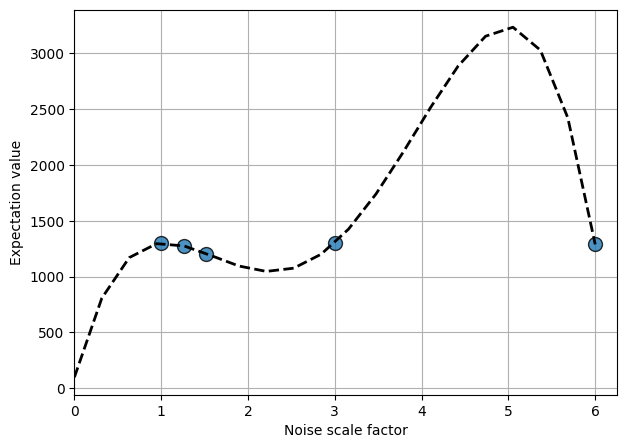

is worse
SAMPLE  92
extrapolalation: 3660.371326903475
expectation_values: [1282.0, 1245.0, 1303.0, 1239.0, 1248.0]


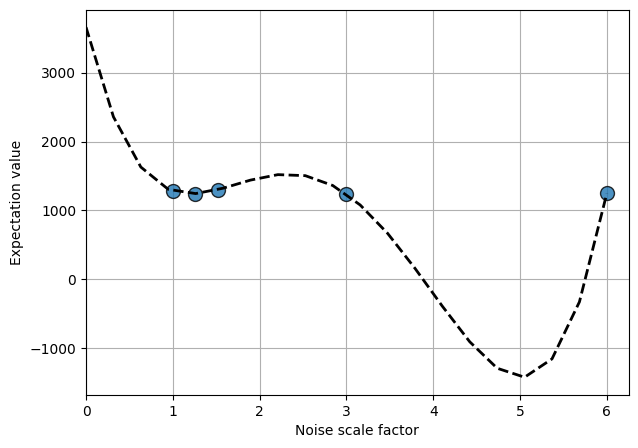

is better!
SAMPLE  93
extrapolalation: 3073.031881720092
expectation_values: [1339.0, 1248.0, 1228.0, 1234.0, 1264.0]


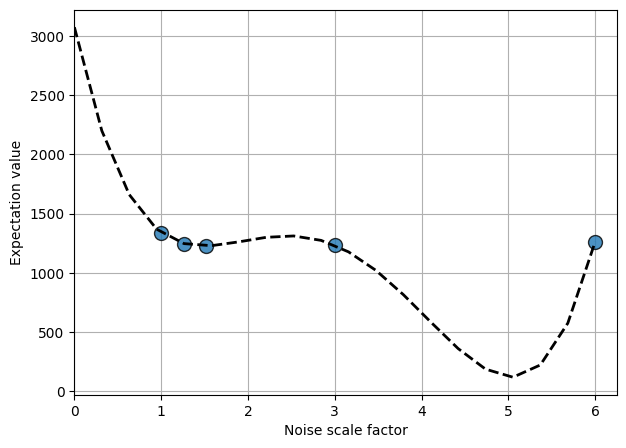

is better!
SAMPLE  94
extrapolalation: 3930.8598303755693
expectation_values: [1338.0, 1251.0, 1269.0, 1244.0, 1301.0]


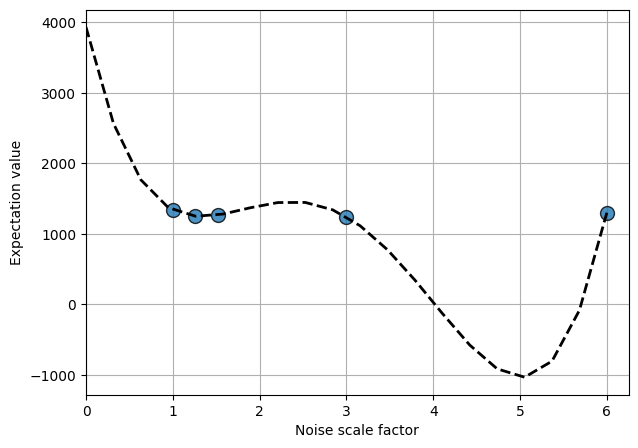

is better!
SAMPLE  95
extrapolalation: 3513.847378313247
expectation_values: [1236.0, 1225.0, 1307.0, 1314.0, 1221.0]


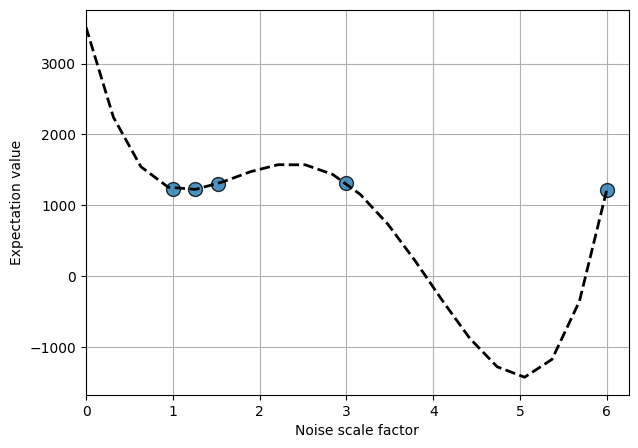

is better!
SAMPLE  96
extrapolalation: 3119.06749084856
expectation_values: [1331.0, 1236.0, 1214.0, 1212.0, 1208.0]


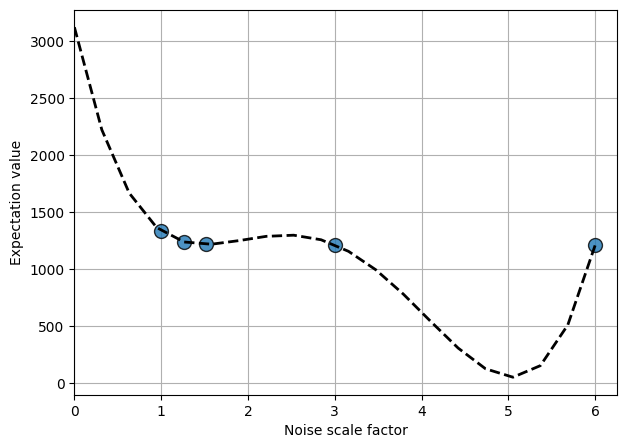

is better!
SAMPLE  97
extrapolalation: -462.53406656752423
expectation_values: [1269.0, 1298.0, 1255.0, 1207.0, 1251.0]


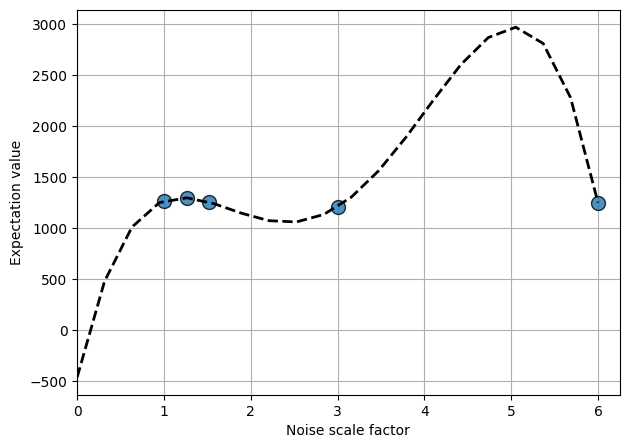

is worse
SAMPLE  98
extrapolalation: 1105.3962091176843
expectation_values: [1257.0, 1235.0, 1208.0, 1245.0, 1234.0]


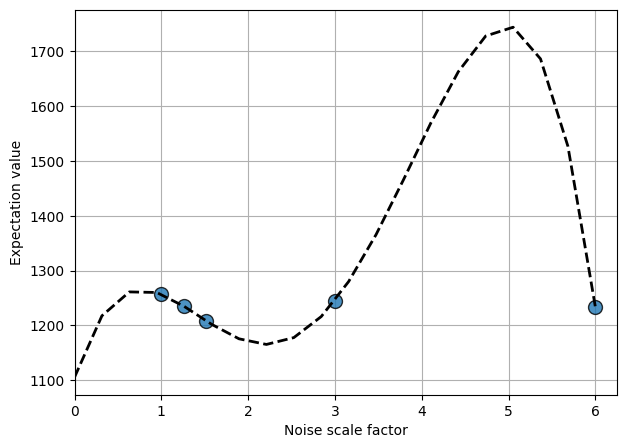

is worse
SAMPLE  99
extrapolalation: 1520.4369325927094
expectation_values: [1348.0, 1281.0, 1223.0, 1283.0, 1279.0]


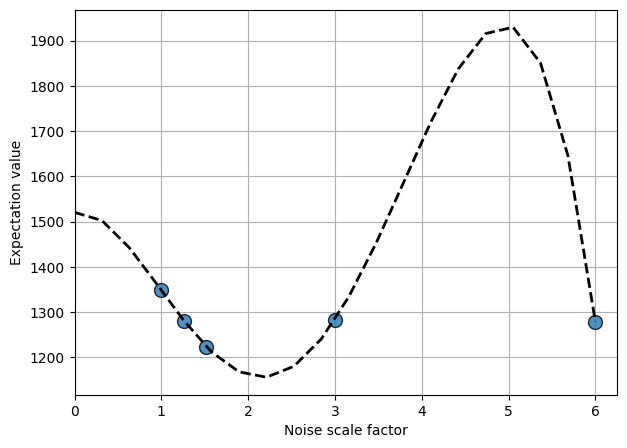

is better!
result:  {'success_prob': 0.68, 'avg_rel_error_on_success': 71.55132739722498, 'avg_rel_error_on_fail': 99.63345975850811, 'rel_error': 80.53760975283558, 'avg_improvement_on_success': 1551.6907896892642, 'avg_deterioration_on_fail': 0, 'avg_improvement_on_fail': 1244.3459758508109}
............................................................
-----------------------------------------------------------
CURRENT QPU: ibm_osaka
-----------------------------------------------------------
............................................................
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence times: all ok
Checking decoherence

{0: 8.918853383e-05,
 1: 0.0001982623342,
 2: 9.12793783e-05,
 3: 0.0004495892418,
 4: 0.0002701074921,
 5: 0.0001552384905,
 6: 0.0009693507205,
 7: 0.0003027638799,
 8: 0.004748875912,
 9: 0.000511742675,
 10: 0.0001256803208,
 11: 0.000410580533,
 12: 0.000117034967,
 13: 0.0003200006905,
 14: 0.0002347147121,
 15: 0.001260803534,
 16: 0,
 17: 0.0001940891915,
 18: 0.0001568395413,
 19: 0.0005155744753,
 20: 0.0001335432797,
 21: 0.0003087242456,
 22: 0.0001455294259,
 23: 0.0002595967605,
 24: 0.0001512613289,
 25: 0.0006902902466,
 26: 0.000806399088,
 27: 0.0001078188692,
 28: 0.0003427382447,
 29: 0.0001123038895,
 30: 0.0001586773179,
 31: 0.0003258919287,
 32: 0.0001119947223,
 33: 0.001453185675,
 34: 0.0001602220535,
 35: 0.00185399627,
 36: 0.0001256239314,
 37: 0.0001428978184,
 38: 0.0001622558481,
 39: 0.0001174533013,
 40: 0.004134548755,
 41: 0.0002128845973,
 42: 0.0003763773028,
 43: 0.0001554078289,
 44: 0.0001732738109,
 45: 0.0003552141582,
 46: 0.0001961352294,
 

------------------------------------------------
TWO QUBITS ERROR RATES:


{'1_0': 0.0035349312945841538,
 '2_3': 0.008976904338163283,
 '2_1': 0.0037036725277592164,
 '3_4': 0.04156694543118522,
 '5_4': 0.008395443181063805,
 '6_7': 0.00944614780580888,
 '6_5': 0.006557028644798429,
 '7_8': 1.0,
 '9_10': 0.008077800626526604,
 '9_8': 1.0,
 '11_10': 0.008824701981358957,
 '12_11': 0.010540326859608928,
 '13_12': 0.0053897540864356885,
 '14_0': 0.005741822029047938,
 '14_18': 0.006465935616365853,
 '15_4': 0.01406752542399145,
 '17_12': 0.0043913927501740835,
 '17_30': 0.00563879994751712,
 '18_19': 0.011326570699073557,
 '20_19': 0.0181246472049873,
 '21_20': 0.005217805685502314,
 '21_22': 0.004164919414085755,
 '22_15': 0.015753486809480466,
 '23_22': 0.0058520466160218165,
 '24_34': 0.0053029306283445266,
 '24_23': 0.023769408447969514,
 '24_25': 0.012037614555577614,
 '25_26': 0.01519202737448544,
 '27_28': 0.005087667822555264,
 '27_26': 0.01320280499236709,
 '28_35': 0.013471808488056902,
 '28_29': 0.004924443750282004,
 '30_29': 0.004843832476151916,
 

------------------------------------------------
MEASUREMENT ERROR RATES:


{0: 0.0272,
 1: 0.0099,
 2: 0.0313,
 3: 0.0283,
 4: 0.1183333333,
 5: 0.03166666667,
 6: 0.0098,
 7: 0.06666666667,
 8: 0.185,
 9: 0.06166666667,
 10: 0.064,
 11: 0.064,
 12: 0.0269,
 13: 0.0055,
 14: 0.1103,
 15: 0.0107,
 16: 0,
 17: 0.0332,
 18: 0.0094,
 19: 0.0131,
 20: 0.0191,
 21: 0.021,
 22: 0.0675,
 23: 0.0071,
 24: 0.0055,
 25: 0.0046,
 26: 0.0109,
 27: 0.0128,
 28: 0.0057,
 29: 0.0057,
 30: 0.0592,
 31: 0.0076,
 32: 0.0111,
 33: 0.0353,
 34: 0.0138,
 35: 0.035,
 36: 0.0105,
 37: 0.0122,
 38: 0.0437,
 39: 0.012,
 40: 0.013,
 41: 0.0098,
 42: 0.004,
 43: 0.0198,
 44: 0.0263,
 45: 0.0293,
 46: 0.1656,
 47: 0.0268,
 48: 0.0237,
 49: 0.0079,
 50: 0.0121,
 51: 0.0299,
 52: 0.016,
 53: 0.0514,
 54: 0.0119,
 55: 0.014,
 56: 0.0228,
 57: 0.0075,
 58: 0.0869,
 59: 0.0621,
 60: 0.1486,
 61: 0.305,
 62: 0.0176,
 63: 0.0062,
 64: 0.0066,
 65: 0.0152,
 66: 0.052,
 67: 0.0499,
 68: 0.0637,
 69: 0.0069,
 70: 0.091,
 71: 0.0213,
 72: 0.0287,
 73: 0.0082,
 74: 0.0439,
 75: 0.0268,
 76: 0.0188,


------------------------------------------------
T1s:
[4.27470603e-04 3.61215181e-04 2.56912421e-04 2.69905730e-04
 3.26954138e-04 2.66883245e-04 2.61721085e-04 3.31247209e-04
 2.12353705e-04 3.51652618e-04 2.73553238e-04 1.82163223e-04
 1.41709977e-04 1.25837226e-04 2.24170888e-04 3.55636400e-04
 4.27470603e-04 2.03781147e-04 4.35925371e-04 3.93105483e-04
 3.71729465e-04 4.84942577e-04 4.31644518e-04 3.65981812e-04
 2.81940676e-04 1.99439782e-04 3.06449717e-04 3.21436936e-04
 3.04120876e-04 3.87488995e-04 2.62755169e-04 1.96144590e-04
 4.65263919e-04 3.12427509e-05 4.03921928e-04 9.35790527e-05
 4.08502119e-04 2.37072356e-04 3.53692591e-04 3.31759920e-04
 7.59731735e-05 1.74647248e-04 2.05452020e-04 3.51358319e-04
 4.53551355e-04 2.77958303e-04 3.69684627e-04 1.80713872e-04
 4.12814861e-04 1.97823663e-04 2.32349194e-04 1.81772993e-04
 2.76902764e-04 4.43907265e-04 4.27630417e-04 3.63370947e-04
 9.41139758e-05 2.50611912e-04 3.69979547e-04 4.22438874e-04
 2.60830865e-04 3.23851787e-04 

{0: 0.0006428211045,
 1: 0.0003793510479,
 2: 0.0003364645537,
 3: 0.0005826297207,
 4: 0.000310477129,
 5: 0.000299373024,
 6: 0.0001300813342,
 7: 0.0001617923984,
 8: 0.0003004170278,
 9: 0.0001214360774,
 10: 0.0002325574531,
 11: 0.0002130774066,
 12: 0.0001415666494,
 13: 0.0001157447177,
 14: 0.0006299329595,
 15: 0.0001764237807,
 16: 0.000305172547,
 17: 0.0001582508844,
 18: 0.0001678078641,
 19: 0.0002597597788,
 20: 0.0001973569466,
 21: 0.0001963777152,
 22: 0.0008451177088,
 23: 0.0001386059567,
 24: 0.0002534694038,
 25: 0.000204763055,
 26: 0.0001864590504,
 27: 0.0003976994271,
 28: 0.0002391099711,
 29: 0.0004825239137,
 30: 0.003962043303,
 31: 0.000280575833,
 32: 0.0001711474135,
 33: 0.001093089391,
 34: 0.000227364309,
 35: 0.0001731278085,
 36: 0.0001173018415,
 37: 0.0005642471283,
 38: 0.0001577711392,
 39: 0.0003573441937,
 40: 0.0001534963873,
 41: 0.0005183201593,
 42: 0.000249809733,
 43: 0.0001805601069,
 44: 0.0001518465244,
 45: 0.0001196460806,
 46: 0.

------------------------------------------------
TWO QUBITS ERROR RATES:


{'0_14': 0.018035439541048914,
 '1_2': 0.011937455773033512,
 '1_0': 0.01967613490330289,
 '3_2': 0.017769528285786262,
 '4_5': 0.009032544381374324,
 '4_3': 0.012081945549001133,
 '6_5': 0.004440222522439835,
 '7_6': 0.007040548993585777,
 '8_16': 0.01342097383031024,
 '8_9': 0.009595266058450763,
 '8_7': 0.010366129133790924,
 '9_10': 0.003834051563445684,
 '11_10': 0.005837110897643355,
 '11_12': 0.0051689828143164085,
 '12_13': 0.007142145324607468,
 '15_4': 0.005180204601593935,
 '16_26': 0.008000212119215727,
 '17_12': 0.005736722855763904,
 '17_30': 0.01774580846617818,
 '18_14': 0.008645332849595094,
 '18_19': 0.00457812696331264,
 '19_20': 0.004778126944136513,
 '21_20': 0.006466807715695216,
 '22_15': 0.017290195532584707,
 '22_21': 0.019075852309061392,
 '22_23': 0.017474663573964128,
 '23_24': 0.009022021812250647,
 '25_26': 0.004883277401722702,
 '25_24': 0.008166529850622717,
 '27_28': 0.008775670462641771,
 '27_26': 0.008551755486072704,
 '28_35': 0.008710160542538037,
 

------------------------------------------------
MEASUREMENT ERROR RATES:


{0: 0.1517,
 1: 0.0807,
 2: 0.0039,
 3: 0.0885,
 4: 0.0505,
 5: 0.0104,
 6: 0.0227,
 7: 0.0151,
 8: 0.0169,
 9: 0.0088,
 10: 0.0315,
 11: 0.0089,
 12: 0.0053,
 13: 0.006,
 14: 0.1054,
 15: 0.0077,
 16: 0.0066,
 17: 0.0095,
 18: 0.1229,
 19: 0.015,
 20: 0.0117,
 21: 0.0078,
 22: 0.0168,
 23: 0.0087,
 24: 0.0229,
 25: 0.0504,
 26: 0.0074,
 27: 0.0073,
 28: 0.0482,
 29: 0.0252,
 30: 0.0537,
 31: 0.007,
 32: 0.0092,
 33: 0.0193,
 34: 0.0341,
 35: 0.0075,
 36: 0.01,
 37: 0.1275,
 38: 0.0163,
 39: 0.0595,
 40: 0.0101,
 41: 0.0096,
 42: 0.005,
 43: 0.0299,
 44: 0.0088,
 45: 0.0077,
 46: 0.011,
 47: 0.0103,
 48: 0.0195,
 49: 0.0056,
 50: 0.0061,
 51: 0.0132,
 52: 0.011,
 53: 0.0107,
 54: 0.0129,
 55: 0.0069,
 56: 0.012,
 57: 0.1213,
 58: 0.0447,
 59: 0.0199,
 60: 0.0067,
 61: 0.0212,
 62: 0.0084,
 63: 0.0065,
 64: 0.0071,
 65: 0.0095,
 66: 0.0141,
 67: 0.0119,
 68: 0.0561,
 69: 0.0206,
 70: 0.0096,
 71: 0.0271,
 72: 0.0123,
 73: 0.0045,
 74: 0.0057,
 75: 0.0538,
 76: 0.1099,
 77: 0.0952,
 78: 

------------------------------------------------
T1s:
[1.93604781e-04 1.45228083e-04 2.21795981e-04 1.75898791e-04
 1.95748685e-04 2.43749897e-04 2.87996960e-04 3.10600864e-04
 1.76630182e-04 2.87348249e-04 2.74610048e-04 2.19964221e-04
 2.60927755e-04 2.37810082e-04 1.57675618e-04 2.41728342e-04
 2.46775298e-04 2.13659633e-04 2.37964075e-04 3.01029779e-04
 2.63936473e-04 2.70275161e-04 2.02073024e-04 3.11145059e-04
 2.20332102e-04 1.90909802e-04 2.85262739e-04 2.31474818e-04
 2.08973835e-04 2.29614990e-04 1.59107735e-04 2.72873684e-04
 2.80557382e-04 2.18761220e-04 2.63057560e-04 3.71969954e-04
 3.24140872e-04 1.76762088e-04 2.51463558e-04 2.75165993e-04
 2.92868937e-04 1.96258185e-04 1.79419795e-04 3.68852655e-04
 3.08281430e-04 2.52291508e-04 3.01463625e-04 3.03671754e-04
 1.79238358e-04 1.57173135e-04 2.00733425e-04 2.65987624e-04
 2.01401660e-04 3.64224708e-04 2.95673096e-04 1.53589878e-04
 2.10945045e-04 2.50055346e-04 3.11803866e-04 2.89541670e-04
 2.30900959e-04 1.20051476e-04 

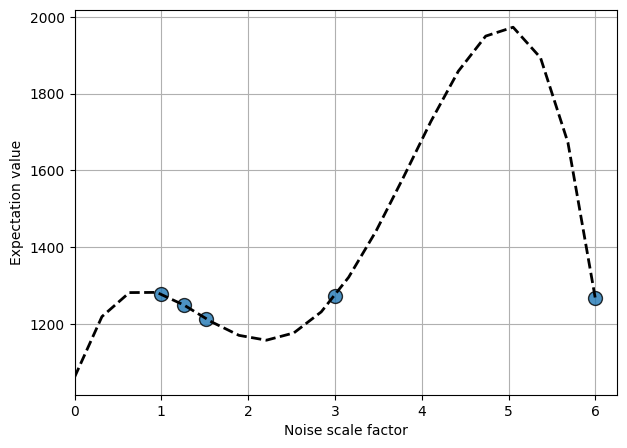

is worse
SAMPLE  1
extrapolalation: -33.63268380212488
expectation_values: [1271.0, 1301.0, 1277.0, 1248.0, 1196.0]


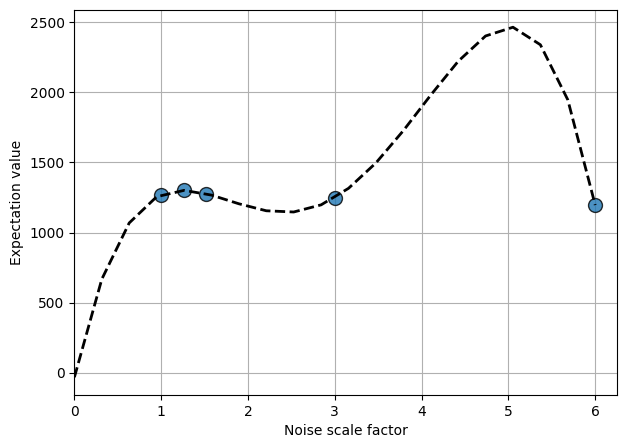

is worse
SAMPLE  2
extrapolalation: 139.84694601051552
expectation_values: [1275.0, 1287.0, 1252.0, 1226.0, 1230.0]


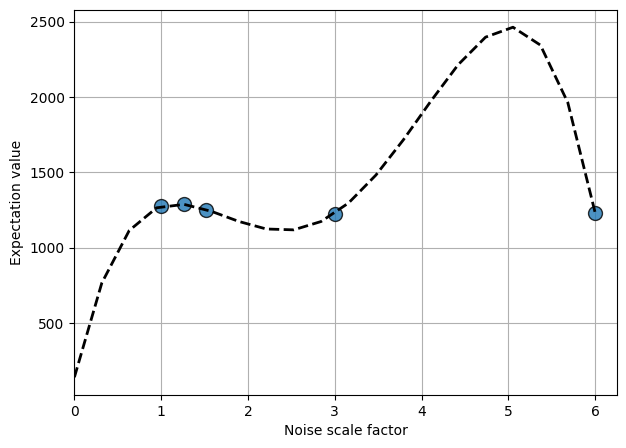

is worse
SAMPLE  3
extrapolalation: -919.8934375649194
expectation_values: [1256.0, 1311.0, 1276.0, 1232.0, 1215.0]


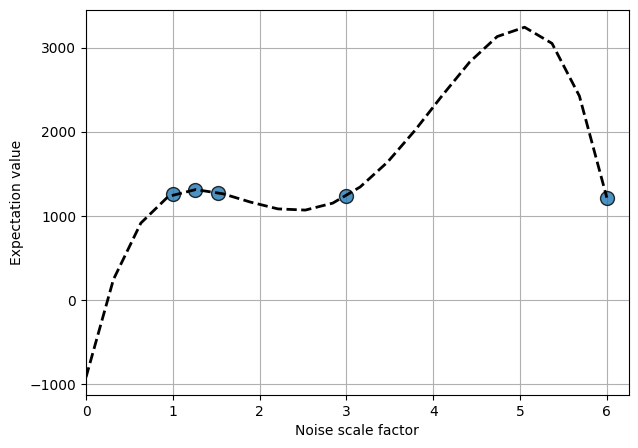

is worse
SAMPLE  4
extrapolalation: 1407.332083063671
expectation_values: [1278.0, 1255.0, 1238.0, 1259.0, 1197.0]


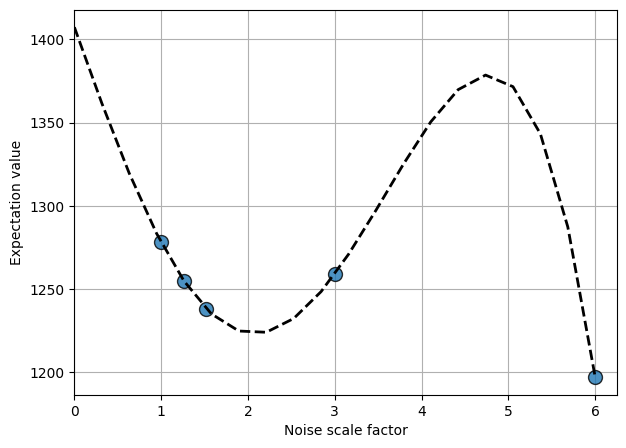

is better!
SAMPLE  5
extrapolalation: 1668.5693160046803
expectation_values: [1267.0, 1284.0, 1316.0, 1270.0, 1174.0]


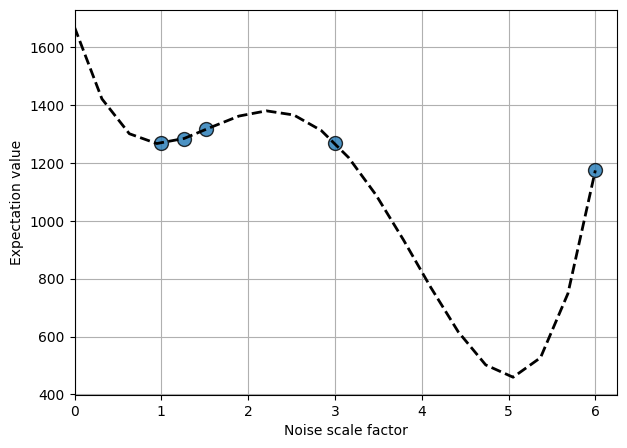

is better!
SAMPLE  6
extrapolalation: -58.50674985148764
expectation_values: [1252.0, 1289.0, 1271.0, 1220.0, 1290.0]


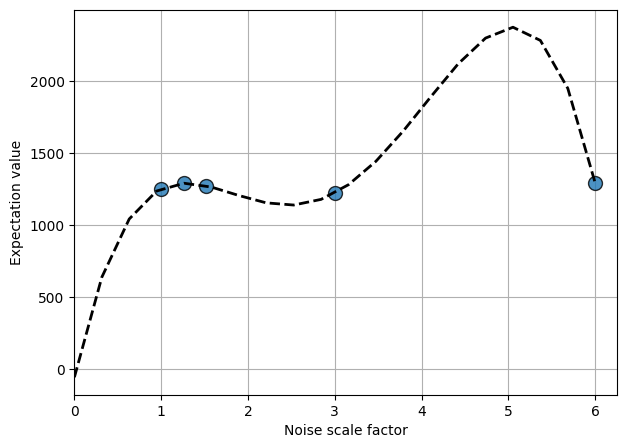

is worse
SAMPLE  7
extrapolalation: 794.224174711224
expectation_values: [1249.0, 1268.0, 1267.0, 1219.0, 1243.0]


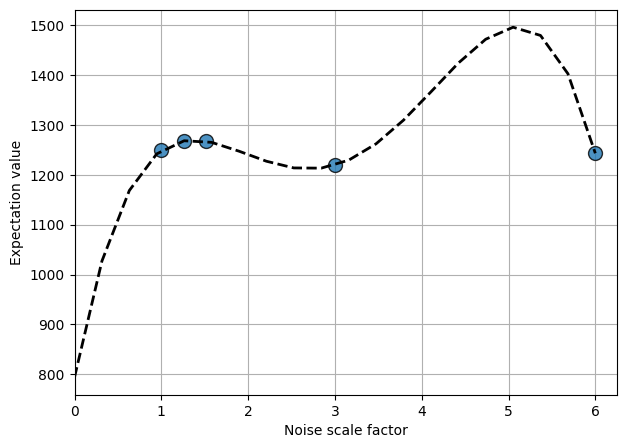

is worse
SAMPLE  8
extrapolalation: -4853.4109101109825
expectation_values: [1244.0, 1334.0, 1177.0, 1225.0, 1252.0]


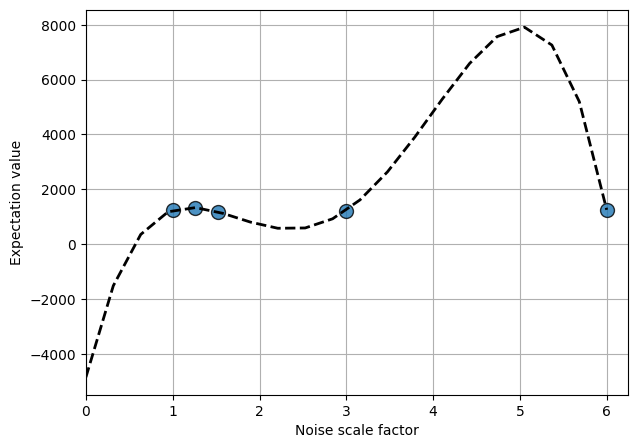

is worse
SAMPLE  9
extrapolalation: -1329.301066690436
expectation_values: [1254.0, 1280.0, 1203.0, 1277.0, 1255.0]


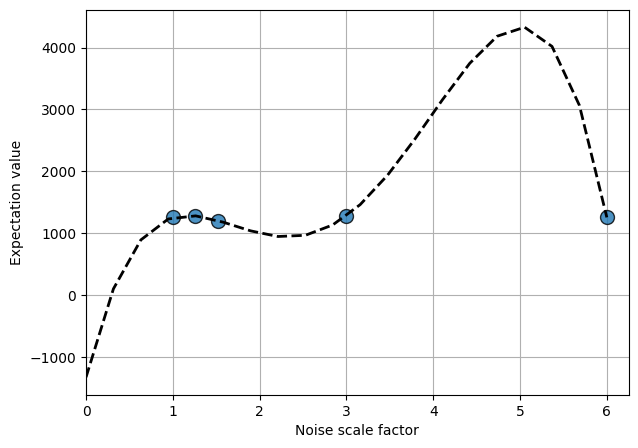

is worse
SAMPLE  10
extrapolalation: -800.0403622867454
expectation_values: [1238.0, 1312.0, 1301.0, 1240.0, 1289.0]


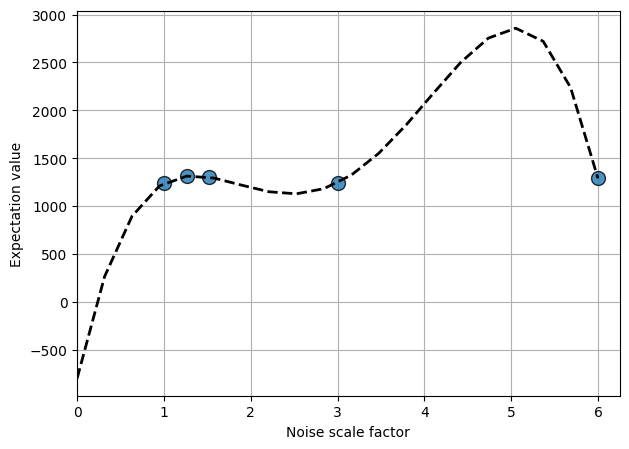

is worse
SAMPLE  11
extrapolalation: 18.168272081242232
expectation_values: [1254.0, 1256.0, 1210.0, 1287.0, 1258.0]


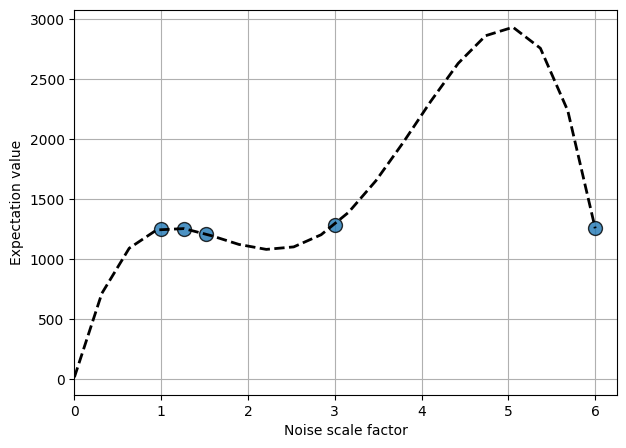

is worse
SAMPLE  12
extrapolalation: 6376.362640007693
expectation_values: [1299.0, 1205.0, 1315.0, 1217.0, 1228.0]


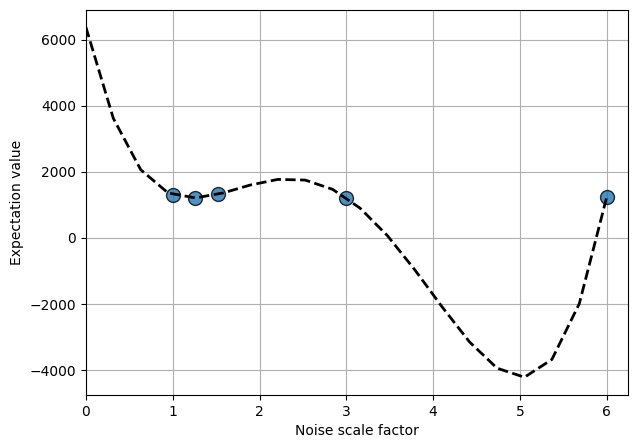

is better!
SAMPLE  13
extrapolalation: 2239.4998949052024
expectation_values: [1237.0, 1236.0, 1275.0, 1249.0, 1289.0]


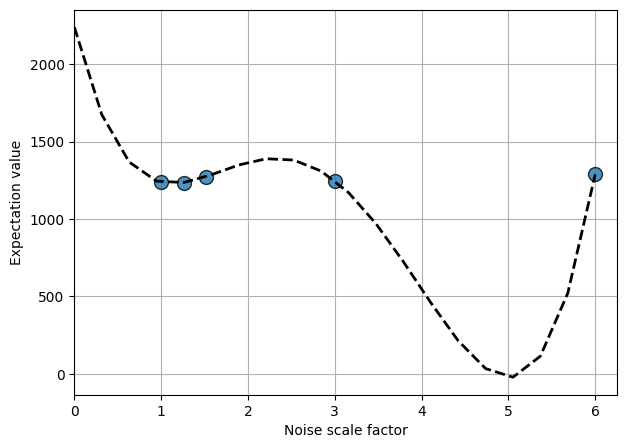

is better!
SAMPLE  14
extrapolalation: 6259.152203951878
expectation_values: [1357.0, 1219.0, 1279.0, 1214.0, 1200.0]


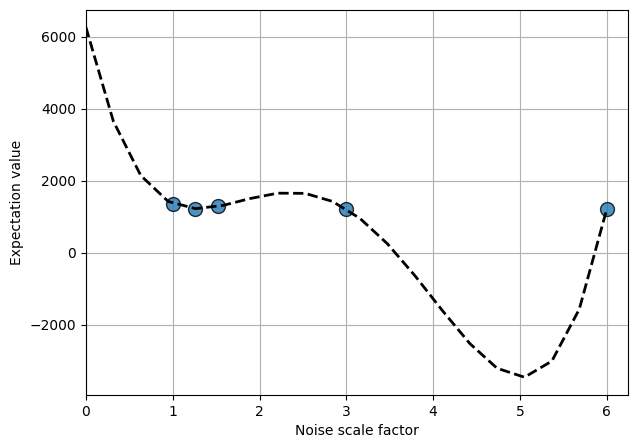

is better!
SAMPLE  15
extrapolalation: 838.2299282132069
expectation_values: [1216.0, 1241.0, 1251.0, 1265.0, 1215.0]


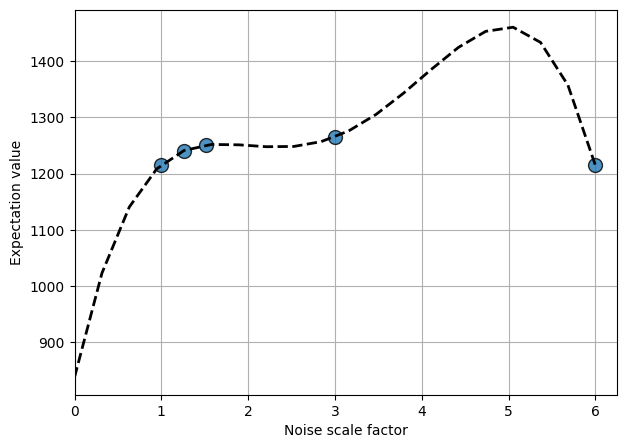

is worse
SAMPLE  16
extrapolalation: 4363.822554330113
expectation_values: [1323.0, 1241.0, 1281.0, 1214.0, 1234.0]


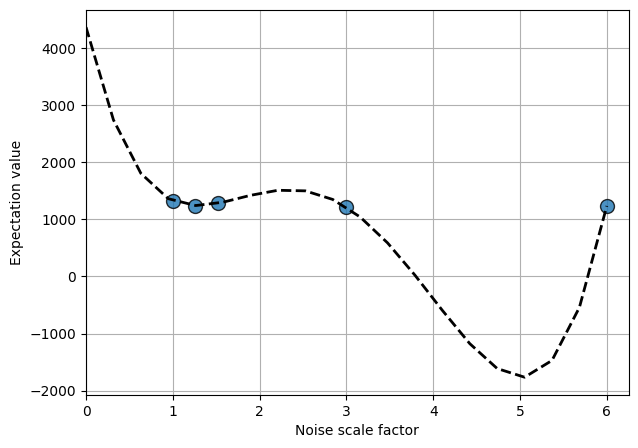

is better!
SAMPLE  17
extrapolalation: 1898.8228015511695
expectation_values: [1305.0, 1274.0, 1267.0, 1259.0, 1292.0]


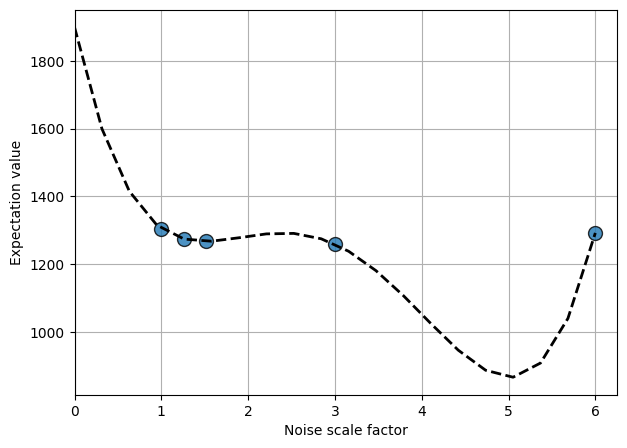

is better!
SAMPLE  18
extrapolalation: 3807.4742558302432
expectation_values: [1296.0, 1245.0, 1294.0, 1215.0, 1247.0]


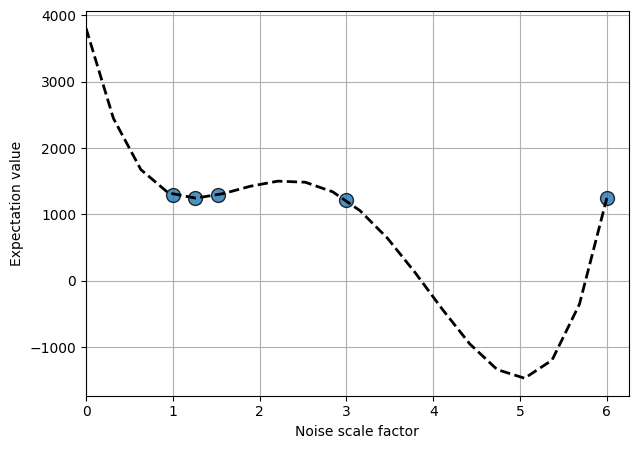

is better!
SAMPLE  19
extrapolalation: -662.5365109533725
expectation_values: [1236.0, 1281.0, 1249.0, 1263.0, 1287.0]


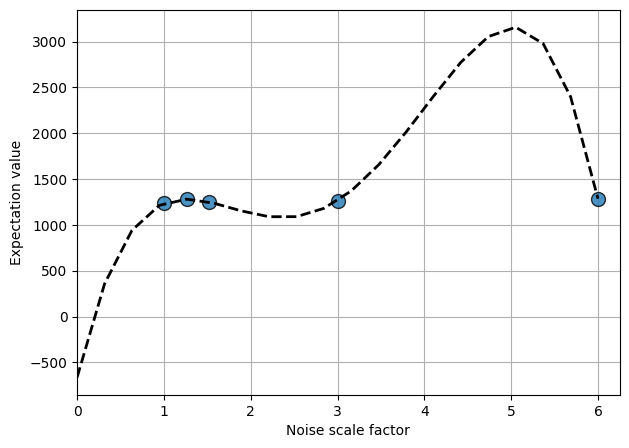

is worse
SAMPLE  20
extrapolalation: 1342.898430542909
expectation_values: [1301.0, 1250.0, 1203.0, 1275.0, 1261.0]


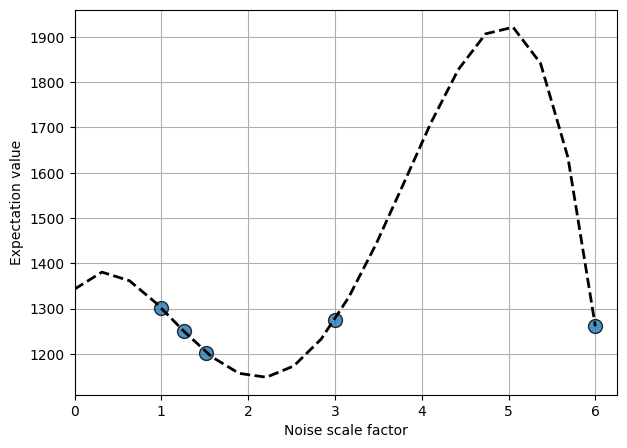

is better!
SAMPLE  21
extrapolalation: 5393.489922138621
expectation_values: [1237.0, 1154.0, 1241.0, 1262.0, 1283.0]


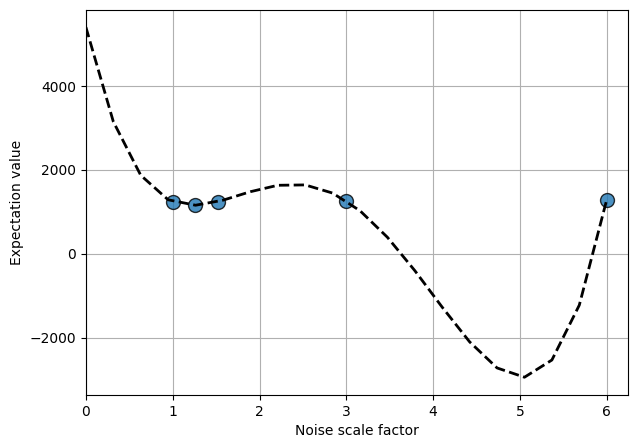

is better!
SAMPLE  22
extrapolalation: 450.12706904082495
expectation_values: [1190.0, 1202.0, 1186.0, 1258.0, 1233.0]


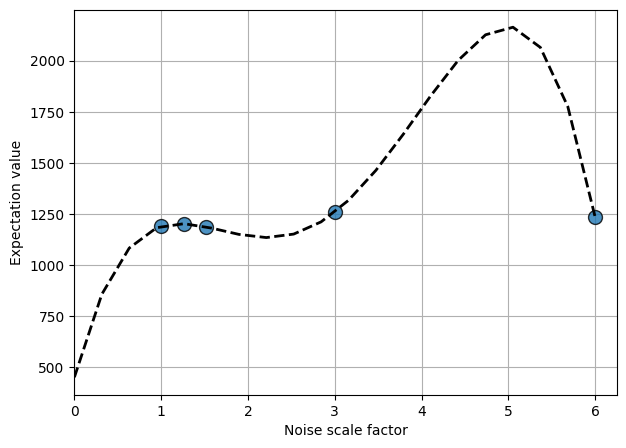

is worse
SAMPLE  23
extrapolalation: -531.6472121180551
expectation_values: [1320.0, 1319.0, 1243.0, 1254.0, 1227.0]


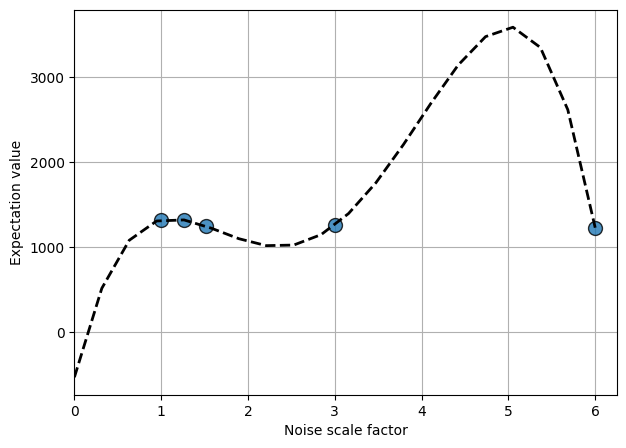

is worse
SAMPLE  24
extrapolalation: -204.24465650308343
expectation_values: [1246.0, 1291.0, 1275.0, 1213.0, 1234.0]


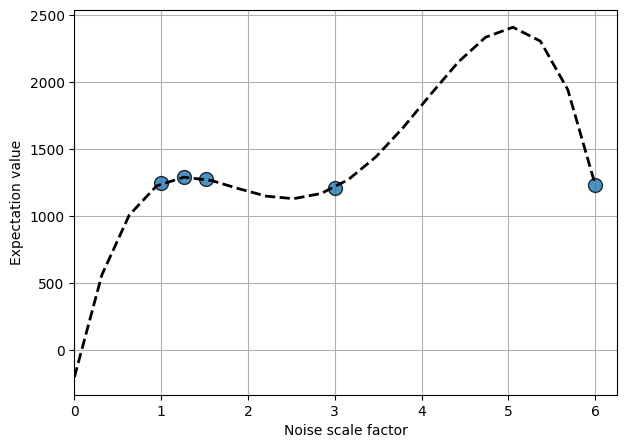

is worse
SAMPLE  25
extrapolalation: 3475.0649682480675
expectation_values: [1272.0, 1213.0, 1245.0, 1285.0, 1302.0]


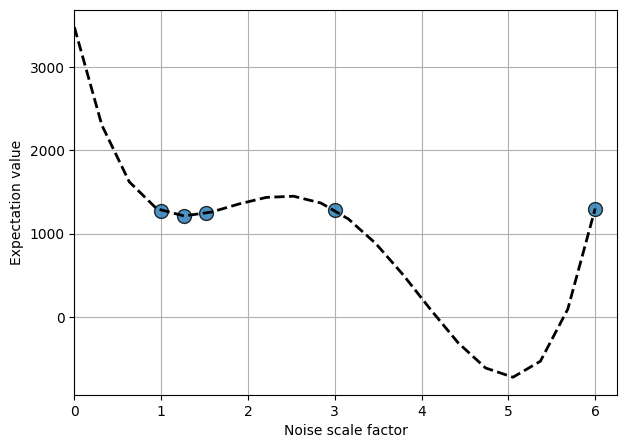

is better!
SAMPLE  26
extrapolalation: 1920.8085390859694
expectation_values: [1273.0, 1267.0, 1287.0, 1274.0, 1268.0]


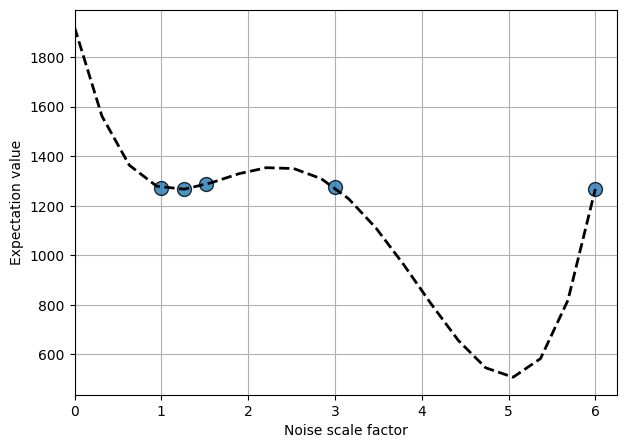

is better!
SAMPLE  27
extrapolalation: -1760.0942953287874
expectation_values: [1241.0, 1291.0, 1219.0, 1229.0, 1254.0]


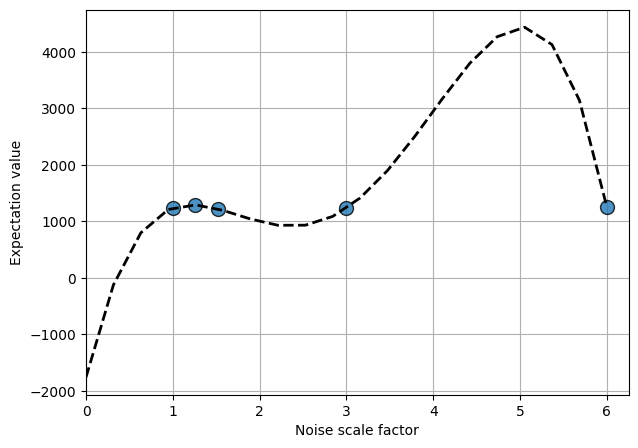

is worse
SAMPLE  28


KeyboardInterrupt: 

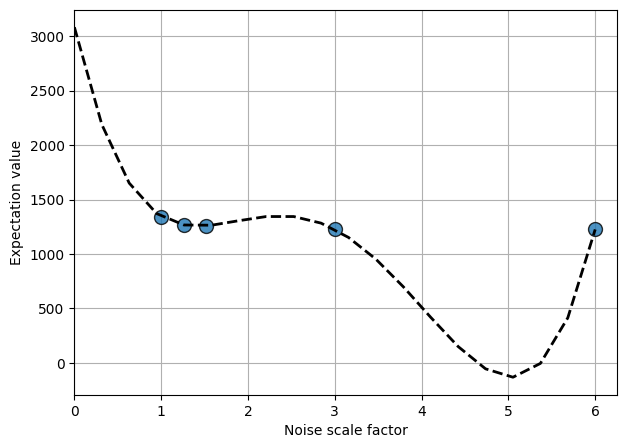

In [60]:
shots = 100000
shots_zne=10000
QPUs = ['ibm_brisbane','ibm_osaka','ibm_kyoto']
conditions = ['qpu','qpu_zne','sim','sim_zne']
pasado = [1,2,3,5,6,7,8,9,10]
#2 no esta, es el errorcito de ECR != CX xdd
itr = 0

for qpu in QPUs:
    print('............................................................')
    print('-----------------------------------------------------------')
    print('CURRENT QPU:',qpu)
    print('-----------------------------------------------------------')
    print('............................................................')
    backend = provider.get_backend(qpu)
    
    unm = Unified_Noise_Model()
    unm.add_calibration_data(str("./"+qpu+".csv"),['id', 'rz', 'sx', 'x'],['ecr'],backend)
    unm.print_calibration_data()
    unm.add_all_noise_channels2()
    simulator = AerSimulator(noise_model=unm.noise_model)
    for condition in conditions:
        itr = itr + 1 
        print('ITRRR',itr)
        if itr in pasado:
            continue
        if condition == 'qpu':
            print('-----------------------------------------------------------')
            print('------------------',qpu,': real hardware-----------------------')
            print('-----------------------------------------------------------') 
            u_inverser_trans= transpile(u_inverser, backend)
            
            dump(u_inverser_trans,'./%s_%s_qasm'%(str(qpu),str(condition)))       
            
            result = backend.run(u_inverser_trans,shots=shots).result()      
           
            with open('./%s_%s_result'%(str(qpu),str(condition)), 'w') as archivo:
                json.dump(result.to_dict(), archivo)
                  
        if condition == 'qpu_zne':
            print('-----------------------------------------------------------')
            print('------------------',qpu,': real hardware+ZNE-----------------------')
            print('-----------------------------------------------------------') 
            u_inverser_trans= transpile(u_inverser, backend,basis_gates=['id', 'rz', 'sx', 'x','cx'])
            
            dump(u_inverser_trans,'./%s_%s_qasm'%(str(qpu),str(condition)))

            zne_result = {}
            fac = RichardsonFactory(scale_factors=[1,1.22,1.44,1.66,2])
            executor =create_executor('000',shots_qpuzne,backend)
            zne_result['000'] = zne.execute_with_zne(u_inverser_trans, executor,factory=fac,scale_noise=fold_gates_at_random,num_to_average=3)
            fac.plot_fit()
            
            plt.savefig("./%s_%s_znefit.png" %(str(qpu),str(condition)))
            with open('./%s_%s_result'%(str(qpu),str(condition)), 'w') as archivo:
                json.dump(zne_result, archivo)

        if condition == 'sim':
            print('-----------------------------------------------------------')
            print('------------------',qpu,': simulation-----------------------')
            print('-----------------------------------------------------------')
            #Mitiq doesnt support ECR. ECR can be decomposed to rz,sx and cx. So, for transpile, we change ECR for cx.
            u_inverser_trans= transpile(u_inverser, backend,basis_gates=['id', 'rz', 'sx', 'x','cx'])
    
            dump(u_inverser_trans,'./%s_%s_qasm'%(str(qpu),str(condition)))

            result = simulator.run(u_inverser_trans,shots=shots).result()      

            with open('./%s_%s_result'%(str(qpu),str(condition)), 'w') as archivo:
                json.dump(result.to_dict(), archivo)

        if condition == 'sim_zne':
            print('-----------------------------------------------------------')
            print('------------------',qpu,': simulation+ZNE-----------------------')
            print('-----------------------------------------------------------') 
            #Mitiq doesnt support ECR. ECR can be decomposed to rz,sx and cx. So, for transpile, we change ECR for cx.
            u_inverser_trans= transpile(u_inverser, backend,basis_gates=['id', 'rz', 'sx', 'x','cx'])     
            dump(u_inverser_trans,'./%s_%s_qasm'%(str(qpu),str(condition)))

            factories = [
                #LinearFactory(scale_factors=[1,6]),
                #RichardsonFactory(scale_factors=[1,2,6]),RichardsonFactory(scale_factors=[1,1.22,1.44,1.66,2]),
                RichardsonFactory(scale_factors=[1,1.26,1.52,3,6])]

            factories_names = D
            for i in range(len(factories)):
                print('ZNE CONF.:',factories_names[i])
                mitigation_experiment(u_inverser_trans,simulator,shots_zne,factories[i],factories_names[i])
                
                executor = create_executor('000',shots_zne,simulator)
                zne.execute_with_zne(u_inverser_trans, executor,factory=factories[i],scale_noise= fold_gates_at_random,num_to_average=1)
                factories[i].plot_fit()
            
                plt.savefig("./%s_%s_%s_fit.png" %(str(qpu),str(condition),str(factories_names[i])))
